In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/S4/PackNet-video-recognition-integration

/content/drive/MyDrive/S4/PackNet-video-recognition-integration


In [ ]:
#%cd /content/drive/MyDrive/works/S4/PackNet-video-recognition-integration

/content/drive/MyDrive/works/S4/PackNet-video-recognition-integration


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from torchsummary import summary
import time
from tqdm import tqdm

from models.base_nets import CLR2Plus1DClassifier
from models.prune import Pruner, init_masks

from dataloader import get_multitask_data, get_singletask_data
from eval_utils import evaluate, task_learning_checkpointing, plot_list, plot_dict, count_parameters

from options import create_parser, init_optim

In [3]:
# Command line Input arguments
parser = create_parser()
args, unknown = parser.parse_known_args()

if args.device == "gpu":
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    device = torch.device("cpu")


# Create multitask datasets
#args.multitask_dataloading = False
args.scenario = "task"
args.classes_per_task = 5
args.tasks = 10

args.multitask_dataloading = True

if args.multitask_dataloading:
    (train_datasets_list, test_datasets_list) = get_multitask_data(tasks=args.tasks, data_dir="./store/datasets")
else:
    (train_dataset_t1, test_dataset_t1) = get_singletask_data(task_id=1, data_dir="./store/datasets")
    (train_dataset_t2, test_dataset_t2) = get_singletask_data(task_id=2, data_dir="./store/datasets")

print("Data loaded")

multihead = True if args.scenario == "task" else False

Data loaded


In [4]:
# define model
model = CLR2Plus1DClassifier(
  layer_sizes=[2, 2, 2, 2],
  classes=args.classes_per_task,
  tasks=args.tasks,
  scenario=args.scenario,
  multihead=multihead).to(device)


# Define optimizer
model.to(device)
(optimizer, scheduler) = init_optim(model, args)
model.optimizer = optimizer
model.scheduler = scheduler

# Visualize model's layers
count_parameters(model)

+---------------------------------------------------------------+----------------------+------------+
|                            Modules                            |         Size         | Parameters |
+---------------------------------------------------------------+----------------------+------------+
|              res2plus1d.conv1.spatial_conv.weight             |   [83, 3, 1, 7, 7]   |   12201    |
|               res2plus1d.conv1.spatial_conv.bias              |         [83]         |     83     |
|            res2plus1d.conv1.bn.batchnorms.0.weight            |         [83]         |     83     |
|             res2plus1d.conv1.bn.batchnorms.0.bias             |         [83]         |     83     |
|            res2plus1d.conv1.bn.batchnorms.1.weight            |         [83]         |     83     |
|             res2plus1d.conv1.bn.batchnorms.1.bias             |         [83]         |     83     |
|            res2plus1d.conv1.bn.batchnorms.2.weight            |         [83]    

In [5]:
summary(model, input_size=(3, 32, 112, 112))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 83, 32, 56, 56]          12,284
       BatchNorm3d-2       [-1, 83, 32, 56, 56]             166
    MultiBatchNorm-3       [-1, 83, 32, 56, 56]               0
              ReLU-4       [-1, 83, 32, 56, 56]               0
            Conv3d-5       [-1, 64, 32, 56, 56]          16,000
SpatioTemporalConv-6       [-1, 64, 32, 56, 56]               0
            Conv3d-7      [-1, 144, 32, 56, 56]          83,088
       BatchNorm3d-8      [-1, 144, 32, 56, 56]             288
    MultiBatchNorm-9      [-1, 144, 32, 56, 56]               0
             ReLU-10      [-1, 144, 32, 56, 56]               0
           Conv3d-11       [-1, 64, 32, 56, 56]          27,712
SpatioTemporalConv-12       [-1, 64, 32, 56, 56]               0
      BatchNorm3d-13       [-1, 64, 32, 56, 56]             128
   MultiBatchNorm-14       [-1, 64, 32

In [6]:
# Copy model without CL capabilities to train it as baseline
if args.base_model:
    base_model = deepcopy(model)
    base_model.to(device)
    (optimizer, scheduler) = init_optim(base_model, args)
    base_model.optimizer = optimizer
    base_model.scheduler = scheduler

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# check if there was a previously saved checkpoint
path = f"cl_r2plus1d_model_taskid_1_retrain.pth.tar"

if os.path.exists('./checkpoints'+'/'+path):
    # loads the checkpoint
    checkpoint = torch.load('./checkpoints'+'/'+path, map_location=torch.device('cpu'))

    last_task_id = checkpoint['last_task_id']
    last_mode = checkpoint['learning_status'] #
    last_epoch = checkpoint['best_epoch'] #
    model.load_state_dict(checkpoint['pruner_state_dict'])
    previous_masks = checkpoint['previous_masks']
    current_masks = checkpoint['current_masks']
    base_model.load_state_dict(checkpoint['base_state_dict'])
    perf_metrics = checkpoint['perf_metrics']

    print("Reloading from previously saved checkpoint")

Reloading from previously saved checkpoint


In [ ]:
last_epoch

24

In [ ]:
# check if there was a previously saved checkpoint
path = f"cl_r2plus1d_model_taskid_2_pretrain.pth.tar"

if os.path.exists('./checkpoints'+'/'+path):
    # loads the checkpoint
    checkpoint = torch.load('./checkpoints'+'/'+path, map_location=torch.device('cpu'))

    last_task_id = checkpoint['last_task_id']
    last_mode = checkpoint['learning_status'] #
    last_epoch = checkpoint['best_epoch'] #
    model.load_state_dict(checkpoint['pruner_state_dict'])
    previous_masks = checkpoint['previous_masks']
    current_masks = checkpoint['current_masks']
    base_model.load_state_dict(checkpoint['base_state_dict'])
    perf_metrics = checkpoint['perf_metrics']

    print("Reloading from previously saved checkpoint")

Reloading from previously saved checkpoint


In [ ]:
# check if there was a previously saved checkpoint
path = f"cl_r2plus1d_model_taskid_2_retrain.pth.tar"

if os.path.exists('./checkpoints'+'/'+path):
    # loads the checkpoint
    checkpoint = torch.load('./checkpoints'+'/'+path, map_location=torch.device('cpu'))

    last_task_id = checkpoint['last_task_id']
    last_mode = checkpoint['learning_status'] #
    last_epoch = checkpoint['best_epoch'] #
    model.load_state_dict(checkpoint['pruner_state_dict'])
    previous_masks = checkpoint['previous_masks']
    current_masks = checkpoint['current_masks']
    base_model.load_state_dict(checkpoint['base_state_dict'])
    perf_metrics = checkpoint['perf_metrics']

    print("Reloading from previously saved checkpoint")

Reloading from previously saved checkpoint


In [ ]:
first_perf_metrics = perf_metrics

In [ ]:
int_perf_metrics = perf_metrics

In [ ]:
last_perf_metrics = perf_metrics

In [ ]:
print(len(last_perf_metrics['accs']['task_1']))
print(len(last_perf_metrics['accs_base']['task_1']), end='\n\n')

91
90



In [ ]:
print(len(int_perf_metrics['accs']['task_1']))
print(len(int_perf_metrics['accs_base']['task_1']), end='\n\n')

print(len(int_perf_metrics['accs']['task_2']))
print(len(int_perf_metrics['accs_base']['task_2']), end='\n\n')

65
64

19
19



In [ ]:
print(len(int_perf_metrics['avg_acc']))
print(len(int_perf_metrics['avg_acc_base']), end='\n\n')

64
64



In [ ]:
for i in range(1, 3):
  print(len(last_perf_metrics['accs'][f'task_{i}']))
  print(len(last_perf_metrics['accs_base'][f'task_{i}']), end='\n\n')

91
90

26
26



In [7]:
device

device(type='cuda')

In [7]:
resume_training = True
if resume_training:
    # check if there was a previously saved checkpoint
    path = f"cl_r2plus1d_model_taskid_5_retrain.pth.tar"

    if os.path.exists('./checkpoints'+'/'+path):
        # loads the checkpoint
        checkpoint = torch.load('./checkpoints'+'/'+path)

        last_task_id = checkpoint['last_task_id']
        last_mode = checkpoint['learning_status'] #
        last_epoch = checkpoint['best_epoch'] #
        model.load_state_dict(checkpoint['pruner_state_dict'])
        previous_masks = checkpoint['previous_masks']
        current_masks = checkpoint['current_masks']
        base_model.load_state_dict(checkpoint['base_state_dict'])
        perf_metrics = checkpoint['perf_metrics']

        print("Reloading from previously saved checkpoint")
else:
    masks = init_masks(model)

Reloading from previously saved checkpoint


In [9]:
last_task_id, last_epoch

(5, 24)

In [ ]:
model.optimizer = checkpoint['pruner_optimizer']

In [ ]:
path = f"last_status_task_5_pretrain_epoch_26.pth.tar"

if os.path.exists('./checkpoints'+'/'+path):
    # loads the checkpoint
    checkpoint = torch.load('./checkpoints/'+path)

    last_task_id = checkpoint['last_task_id']
    mode = checkpoint['learning_status']
    epoch = checkpoint['last_epoch']
    metrics_old = checkpoint['perf_metrics']

In [ ]:
path = f"last_status.pth.tar"

if os.path.exists('./checkpoints'+'/'+path):
    # loads the checkpoint
    checkpoint = torch.load('./checkpoints/'+path)

    last_task_id = checkpoint['last_task_id']
    mode = checkpoint['learning_status']
    epoch = checkpoint['last_epoch']
    metrics_ltst = checkpoint['perf_metrics']

In [ ]:
epoch, last_task_id, mode

(24, 5, 'retrain')

In [ ]:
len(metrics_ltst['accs']['task_5']), len(metrics_old['accs']['task_5'])

(19, 26)

In [ ]:
metrics_ltst['accs']['task_5'][0:0] = metrics_old['accs']['task_5']

In [ ]:
len(metrics_ltst['accs']['task_5'])

45

In [ ]:
metrics_ltst['accs_base']['task_5'][0:0] = metrics_old['accs_base']['task_5']

In [ ]:
metrics_ltst

In [ ]:
emerg_path = f"./checkpoints/last_status.pth.tar"
torch.save({
    'last_task_id': last_task_id,
    'learning_status':mode,
    'last_epoch':epoch,
    'perf_metrics': metrics_ltst,
}, emerg_path)

In [8]:
if not resume_training:
    pruner = Pruner(
      model,
      prune_perc=args.prune_perc,
      previous_masks=masks,
      train_bias=False,
      train_bn=True,
      device=device,
      )
else:
    pruner = Pruner(
      model,
      prune_perc=args.prune_perc,
      previous_masks=previous_masks,
      train_bias=False,
      train_bn=True,
      device=device,
      )
    pruner.current_masks = pruner.previous_masks

### Task 1

In [ ]:
perf_metrics = {'accs':dict(), 'accs_base':dict(),
                'avg_acc':[], 'avg_acc_base':[],
                'avg_test_loss':[], 'avg_test_loss_base':[],
                'train_losses':[], 'train_losses_base':[]}

In [ ]:
train_dataloader_t1 = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_dataloaders_t1 = DataLoader(test_dataset, batch_size=14)

In [ ]:
valid_dataloaders_t1 = list([valid_dataloaders_t1])

In [ ]:
t = 0
train_dataloaders_t = train_dataloader_t1  # train_dataloader_t1[t]
valid_dataloaders_t = valid_dataloaders_t1[:t+1]

In [ ]:
# Sequential training for each task

print("\n----------- TASK {} ------------".format(t + 1))

start = time.time()
epoch_resume = 0

## task_learning_early stoping
es_thresh = 10
best_acc = -1
best_epoch = -1

# List to store accuracy for current task
perf_metrics['accs']["task_" + str(t + 1)] = []
perf_metrics['accs_base']["task_" + str(t + 1)] = []

for i in tqdm(range(epoch_resume, args.epochs), unit="epochs", initial=epoch_resume, total=args.epochs):
    print(f"Epoch {i + 1}\n-------------------------------")
    # Train pruned model
    train_loss = pruner.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
    perf_metrics['train_losses'].append(train_loss)

    # Evaluating tasks seen so far
    print("\n-----PACKNET model TEST Accuracies-----")
    acc_sum, loss_sum = 0.0, 0.0
    end_train = None
    for t_s in range(t + 1):
        # Test pruned model
        puner_copy = deepcopy(pruner)
        # Copy is needed - weights with mask_idx > dataset_idx are set to '0'
        puner_copy.apply_mask(dataset_idx=t_s + 1)
        acc, loss = puner_copy.model.test_epoch(valid_dataloaders_t[t_s], loss_fn, device, task_nr=t_s)
        if t_s == t:
          end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model,
                                       perf_metrics, task_id=t_s+1, mode='pretrain')
          if end_train == 'yes':
              break
        perf_metrics['accs']["task_" + str(t_s + 1)].append(acc)
        acc_sum += acc
        loss_sum += loss

    if end_train == 'yes':
      break

    # Update average accuracy
    perf_metrics['avg_acc'].append(acc_sum / (t + 1))
    # Update average test loss
    perf_metrics['avg_test_loss'].append(loss_sum / (t + 1))

    # Train base model
    if args.base_model:
        train_loss_base = base_model.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
        perf_metrics['train_losses_base'].append(train_loss_base)
        # Test base model
        print("\n-----BASE model TEST Accuracies-----")
        perf_metrics['accs_base'], perf_metrics['avg_acc_base'], perf_metrics['avg_test_loss_base'] = evaluate(
            base_model,
            valid_dataloaders_t,
            perf_metrics['accs_base'],
            perf_metrics['avg_acc_base'],
            perf_metrics['avg_test_loss_base'],
            loss_fn,
            device,
            task_nr=t,
            verbose=True,
        )
        # Reset optimizer
        base_model.optimizer = init_optim(base_model, args)

# Perform pruning
pruner.prune()
pruner.make_pruned_zero()

# Retrain pruned model
for i in range(args.retrain_epochs):
    print(f"Retraining pruned model, Epoch {i + 1}\n-------------------------------")
    pruner.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
    puner_copy = deepcopy(pruner)
    puner_copy.apply_mask(dataset_idx=t + 1)
    acc, test_loss = puner_copy.model.test_epoch(valid_dataloaders_t[t], loss_fn, device, task_nr=t)
    end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model, perf_metrics, task_id=t+1, mode='retrain')
    if end_train == 'yes':
        break
print(f"Prunig after TASK {t+1} ended")

# Make pruned params available for new dataset.
pruner.make_finetuning_mask()

# Reset optimizer
pruner.model.optimizer = init_optim(pruner.model, args) #optim.Adam(model.parameters(), lr, betas, 1e-08, weight_decay)
#pruner.model.scheduler = reset_optimiser_scheduler(model)[1]

time_elapsed = time.time() - start
print(f"Training complete in {time_elapsed//3600}h {(time_elapsed%3600)//60}m {time_elapsed %60}s")

### Task 2

In [ ]:
train_dataloader_t2 = DataLoader(train_dataset_t2, batch_size=10, shuffle=True)
valid_dataloader_t2 = DataLoader(test_dataset_t2, batch_size=14)

In [ ]:
valid_dataloader_t1 = DataLoader(test_dataset_t1, batch_size=14)

In [ ]:
valid_dataloaders_t2 = list([valid_dataloader_t1, valid_dataloader_t2])

In [ ]:
t = 1
train_dataloaders_t = train_dataloader_t2  # train_dataloader_t1[t]
valid_dataloaders_t = valid_dataloaders_t2[:t+1]

In [ ]:
# Sequential training for each task

print("\n----------- TASK {} ------------".format(t + 1))

start = time.time()
epoch_resume = 0

## task_learning_early stoping
es_thresh = 10
best_acc = -1
best_epoch = -1

# List to store accuracy for current task
perf_metrics['accs']["task_" + str(t + 1)] = []
perf_metrics['accs_base']["task_" + str(t + 1)] = []

for i in tqdm(range(epoch_resume, args.epochs), unit="epochs", initial=epoch_resume, total=args.epochs):
    print(f"Epoch {i + 1}\n-------------------------------")
    # Train pruned model
    train_loss = pruner.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
    perf_metrics['train_losses'].append(train_loss)

    # Evaluating tasks seen so far
    print("\n-----PACKNET model TEST Accuracies-----")
    acc_sum, loss_sum = 0.0, 0.0
    end_train = None
    for t_s in range(t + 1):
        # Test pruned model
        puner_copy = deepcopy(pruner)
        # Copy is needed - weights with mask_idx > dataset_idx are set to '0'
        puner_copy.apply_mask(dataset_idx=t_s + 1)
        acc, loss = puner_copy.model.test_epoch(valid_dataloaders_t[t_s], loss_fn, device, task_nr=t_s)
        if t_s == t:
          end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model,
                                       perf_metrics, task_id=t_s+1, mode='pretrain')
          if end_train == 'yes':
              break
        perf_metrics['accs']["task_" + str(t_s + 1)].append(acc)
        acc_sum += acc
        loss_sum += loss

    if end_train == 'yes':
      break

    # Update average accuracy
    perf_metrics['avg_acc'].append(acc_sum / (t + 1))
    # Update average test loss
    perf_metrics['avg_test_loss'].append(loss_sum / (t + 1))

    # Train base model
    if args.base_model:
        train_loss_base = base_model.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
        perf_metrics['train_losses_base'].append(train_loss_base)
        # Test base model
        print("\n-----BASE model TEST Accuracies-----")
        perf_metrics['accs_base'], perf_metrics['avg_acc_base'], perf_metrics['avg_test_loss_base'] = evaluate(
            base_model,
            valid_dataloaders_t,
            perf_metrics['accs_base'],
            perf_metrics['avg_acc_base'],
            perf_metrics['avg_test_loss_base'],
            loss_fn,
            device,
            task_nr=t,
            verbose=True,
        )
        # Reset optimizer
        base_model.optimizer = init_optim(base_model, args)

# Perform pruning
pruner.prune()
pruner.make_pruned_zero()

# Retrain pruned model
for i in range(args.retrain_epochs):
    print(f"Retraining pruned model, Epoch {i + 1}\n-------------------------------")
    pruner.train_epoch(train_dataloaders_t, loss_fn, device, task_nr=t)
    puner_copy = deepcopy(pruner)
    puner_copy.apply_mask(dataset_idx=t + 1)
    acc, test_loss = puner_copy.model.test_epoch(valid_dataloaders_t[t], loss_fn, device, task_nr=t)
    end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model, perf_metrics, task_id=t+1, mode='retrain')
    if end_train == 'yes':
        break
print(f"Prunig after TASK {t+1} ended")

# Make pruned params available for new dataset.
pruner.make_finetuning_mask()

# Reset optimizer
pruner.model.optimizer = init_optim(pruner.model, args) #optim.Adam(model.parameters(), lr, betas, 1e-08, weight_decay)
#pruner.model.scheduler = reset_optimiser_scheduler(model)[1]

time_elapsed = time.time() - start
print(f"Training complete in {time_elapsed//3600}h {(time_elapsed%3600)//60}m {time_elapsed %60}s")

In [9]:
train_bs = 10
valid_bs = 14

train_dataloaders = []
valid_dataloaders = []
for t in range(args.tasks):
    # Training DLs
    dl_train = DataLoader(train_datasets_list[t], batch_size=train_bs, shuffle=True)
    train_dataloaders.append(dl_train)
    # Testing DLs
    dl_test = DataLoader(test_datasets_list[t], batch_size=valid_bs, shuffle=False)
    valid_dataloaders.append(dl_test)

In [12]:
last_task_id, last_epoch

(5, 24)

In [ ]:
t = 5

In [ ]:
# Sequential training for each task
t = 5
start = time.time()
epoch_resume = last_epoch

## task_learning_early stoping
es_thresh = 10
best_acc = -1
best_epoch = -1

print("\n----------- TASK {} ------------".format(t + 1))
# List to store accuracy for current task
perf_metrics['accs']["task_" + str(t + 1)] = []
perf_metrics['accs_base']["task_" + str(t + 1)] = []


for i in tqdm(range(epoch_resume, args.epochs), unit="epochs", initial=epoch_resume, total=args.epochs):
    print(f"Epoch {i + 1}\n-------------------------------")
    # Train pruned model
    train_loss = pruner.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
    perf_metrics['train_losses'].append(train_loss)

    # Evaluating tasks seen so far
    print("\n-----PACKNET model TEST Accuracies-----")
    acc_sum, loss_sum = 0.0, 0.0
    end_train = None
    for t_s in range(t + 1):
        # Test pruned model
        puner_copy = deepcopy(pruner)
        # Copy is needed - weights with mask_idx > dataset_idx are set to '0'
        puner_copy.apply_mask(dataset_idx=t_s + 1)
        acc, loss = puner_copy.model.test_epoch(valid_dataloaders[t_s], loss_fn, device, task_nr=t_s)
        if t_s == t:
            end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model,
                                      perf_metrics, task_id=t_s+1, mode='pretrain')
            if end_train == 'yes':
                break
        perf_metrics['accs']["task_" + str(t_s + 1)].append(acc)
        acc_sum += acc
        loss_sum += loss

    if end_train == 'yes':
        break

    # Update average accuracy
    perf_metrics['avg_acc'].append(acc_sum / (t + 1))
    # Update average test loss
    perf_metrics['avg_test_loss'].append(loss_sum / (t + 1))

    # Train base model
    if args.base_model:
        train_loss_base = base_model.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
        perf_metrics['train_losses_base'].append(train_loss_base)
        # Test base model
        print("\n-----BASE model TEST Accuracies-----")
        perf_metrics['accs_base'], perf_metrics['avg_acc_base'], perf_metrics['avg_test_loss_base'] = evaluate(
            base_model,
            valid_dataloaders,
            perf_metrics['accs_base'],
            perf_metrics['avg_acc_base'],
            perf_metrics['avg_test_loss_base'],
            loss_fn,
            device,
            task_nr=t,
            verbose=True,
        )
        # Reset optimizer
        (optimizer, scheduler) = init_optim(base_model, args)
        base_model.optimizer = optimizer
        base_model.scheduler = scheduler

# Perform pruning
pruner.prune()
pruner.make_pruned_zero()

# Retrain pruned model
for i in range(args.retrain_epochs):
    print(f"Retraining pruned model, Epoch {i + 1}\n-------------------------------")
    pruner.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
    puner_copy = deepcopy(pruner)
    puner_copy.apply_mask(dataset_idx=t + 1)
    acc, test_loss = puner_copy.model.test_epoch(valid_dataloaders[t], loss_fn, device, task_nr=t)
    end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model, perf_metrics, task_id=t+1, mode='retrain')
    if end_train == 'yes':
        break
print(f"Prunig after TASK {t+1} ended")

# Make pruned params available for new dataset.
pruner.make_finetuning_mask()

# Reset optimizer
(optimizer, scheduler) = init_optim(pruner.model, args)
pruner.model.optimizer = optimizer
pruner.model.scheduler = scheduler

time_elapsed = time.time() - start
print(f"Training complete in {time_elapsed//3600}h {(time_elapsed%3600)//60}m {time_elapsed %60}s")


----------- TASK 6 ------------


 53%|█████▎    | 24/45 [00:00<?, ?epochs/s]

Epoch 25
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


loss: 1.512069  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 19.26%, Avg loss: 1.703734 

loss: 1.705794  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 31.514967 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 44.722790 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 15.691751 

TASK 4 Test Accuracy: 
 Accuracy: 19.71%, Avg loss: 25.774021 

TASK 5 Test Accuracy: 
 Accuracy: 27.41%, Avg loss: 6.118601 



 56%|█████▌    | 25/45 [26:02<8:40:40, 1562.02s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 40.00%, Avg loss: 1.501044 

Epoch 26
-------------------------------
loss: 1.635679  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 18.52%, Avg loss: 1.700619 

loss: 1.147344  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 25.201927 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 35.511988 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 20.177328 

TASK 4 Test Accuracy: 
 Accuracy: 19.71%, Avg loss: 22.138736 

TASK 5 Test Accuracy: 
 Accuracy: 25.93%, Avg loss: 6.680900 



 58%|█████▊    | 26/45 [35:50<5:13:14, 989.16s/epochs] 

TASK 6 Test Accuracy: 
 Accuracy: 41.48%, Avg loss: 1.415903 

Epoch 27
-------------------------------
loss: 1.494982  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 17.78%, Avg loss: 1.668919 

loss: 0.854325  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 22.671119 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 33.061299 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 20.648353 

TASK 4 Test Accuracy: 
 Accuracy: 18.98%, Avg loss: 22.734766 

TASK 5 Test Accuracy: 
 Accuracy: 28.89%, Avg loss: 6.001953 



 60%|██████    | 27/45 [45:38<4:01:51, 806.17s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 47.41%, Avg loss: 1.417926 

Epoch 28
-------------------------------
loss: 1.439114  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 25.93%, Avg loss: 1.699055 

loss: 0.965750  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 24.581255 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 31.723917 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 21.597974 

TASK 4 Test Accuracy: 
 Accuracy: 18.25%, Avg loss: 21.678296 

TASK 5 Test Accuracy: 
 Accuracy: 25.19%, Avg loss: 7.366608 



 62%|██████▏   | 28/45 [55:30<3:24:26, 721.54s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 51.11%, Avg loss: 1.317685 

Epoch 29
-------------------------------
loss: 1.296631  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 24.44%, Avg loss: 1.719057 

loss: 0.464021  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 18.607691 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 26.971257 

TASK 3 Test Accuracy: 
 Accuracy: 33.09%, Avg loss: 10.453005 

TASK 4 Test Accuracy: 
 Accuracy: 13.14%, Avg loss: 24.059157 

TASK 5 Test Accuracy: 
 Accuracy: 42.96%, Avg loss: 4.505054 



 64%|██████▍   | 29/45 [1:05:18<2:59:32, 673.28s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 40.74%, Avg loss: 1.987760 

Epoch 30
-------------------------------
loss: 1.221625  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 21.48%, Avg loss: 1.686125 

loss: 0.121902  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.21%, Avg loss: 19.070143 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 26.617236 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 19.797657 

TASK 4 Test Accuracy: 
 Accuracy: 11.68%, Avg loss: 20.140368 

TASK 5 Test Accuracy: 
 Accuracy: 28.89%, Avg loss: 4.519644 



 67%|██████▋   | 30/45 [1:15:04<2:40:58, 643.91s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 44.44%, Avg loss: 1.868077 

Epoch 31
-------------------------------
loss: 1.420424  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 25.19%, Avg loss: 1.715161 

loss: 0.176682  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 14.261357 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 13.587585 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 12.143057 

TASK 4 Test Accuracy: 
 Accuracy: 11.68%, Avg loss: 16.385314 

TASK 5 Test Accuracy: 
 Accuracy: 45.19%, Avg loss: 2.350353 



 69%|██████▉   | 31/45 [1:24:50<2:25:48, 624.89s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 46.67%, Avg loss: 1.715429 

Epoch 32
-------------------------------
loss: 1.188563  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 22.22%, Avg loss: 1.686153 

loss: 0.162132  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 28.059466 

TASK 2 Test Accuracy: 
 Accuracy: 26.72%, Avg loss: 12.307753 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 15.791433 

TASK 4 Test Accuracy: 
 Accuracy: 15.33%, Avg loss: 8.378957 

TASK 5 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 7.559367 



 71%|███████   | 32/45 [1:34:37<2:12:47, 612.87s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 21.48%, Avg loss: 4.582670 

Epoch 33
-------------------------------
loss: 1.228429  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 26.67%, Avg loss: 1.672416 

loss: 0.417795  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 19.127420 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 20.192461 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 13.404273 

TASK 4 Test Accuracy: 
 Accuracy: 16.79%, Avg loss: 21.095102 

TASK 5 Test Accuracy: 
 Accuracy: 31.11%, Avg loss: 4.468125 



 73%|███████▎  | 33/45 [1:44:24<2:00:57, 604.76s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 48.15%, Avg loss: 1.923849 

Epoch 34
-------------------------------
loss: 1.274444  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 20.74%, Avg loss: 1.715361 

loss: 0.123649  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 17.915686 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 21.420235 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 8.291205 

TASK 4 Test Accuracy: 
 Accuracy: 5.84%, Avg loss: 23.065097 

TASK 5 Test Accuracy: 
 Accuracy: 27.41%, Avg loss: 4.016509 



 76%|███████▌  | 34/45 [1:54:12<1:49:53, 599.36s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 45.19%, Avg loss: 1.635867 

Epoch 35
-------------------------------
loss: 1.210119  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 24.44%, Avg loss: 1.665856 

loss: 0.108518  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.21%, Avg loss: 15.145857 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 23.027645 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 11.958749 

TASK 4 Test Accuracy: 
 Accuracy: 16.06%, Avg loss: 23.293493 

TASK 5 Test Accuracy: 
 Accuracy: 36.30%, Avg loss: 4.257075 



 78%|███████▊  | 35/45 [2:03:59<1:39:16, 595.68s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 34.81%, Avg loss: 2.055709 

Epoch 36
-------------------------------
loss: 0.890831  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 25.93%, Avg loss: 1.757724 

loss: 0.747825  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 16.817233 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 18.848663 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 10.860388 

TASK 4 Test Accuracy: 
 Accuracy: 23.36%, Avg loss: 20.865789 

TASK 5 Test Accuracy: 
 Accuracy: 25.93%, Avg loss: 3.735063 



 80%|████████  | 36/45 [2:13:47<1:28:59, 593.28s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 45.19%, Avg loss: 2.180484 

Epoch 37
-------------------------------
loss: 0.884207  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 28.15%, Avg loss: 1.595689 

loss: 0.094791  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 23.48%, Avg loss: 14.902287 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 18.412518 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 9.648421 

TASK 4 Test Accuracy: 
 Accuracy: 20.44%, Avg loss: 21.458304 

TASK 5 Test Accuracy: 
 Accuracy: 34.07%, Avg loss: 3.272871 



 82%|████████▏ | 37/45 [2:23:35<1:18:55, 591.91s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 36.30%, Avg loss: 1.710669 

Epoch 38
-------------------------------
loss: 0.945360  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 26.67%, Avg loss: 1.599908 

loss: 0.031997  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 23.48%, Avg loss: 16.646708 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 19.473715 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 7.547336 

TASK 4 Test Accuracy: 
 Accuracy: 19.71%, Avg loss: 26.037960 

TASK 5 Test Accuracy: 
 Accuracy: 28.89%, Avg loss: 4.251467 



 84%|████████▍ | 38/45 [2:33:24<1:08:56, 590.97s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 40.74%, Avg loss: 1.727077 

Epoch 39
-------------------------------
loss: 1.021123  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 31.85%, Avg loss: 1.642954 

loss: 0.077923  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 20.988425 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.423739 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 8.243456 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 28.142428 

TASK 5 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 10.073907 



 87%|████████▋ | 39/45 [2:43:01<58:40, 586.74s/epochs]  

TASK 6 Test Accuracy: 
 Accuracy: 37.78%, Avg loss: 6.693252 

Epoch 40
-------------------------------
loss: 1.248907  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 28.15%, Avg loss: 1.566721 

loss: 0.282764  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 17.620323 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 20.039956 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 5.496622 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 30.723787 

TASK 5 Test Accuracy: 
 Accuracy: 32.59%, Avg loss: 6.407419 



 89%|████████▉ | 40/45 [2:52:48<48:54, 586.82s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 48.15%, Avg loss: 2.027570 

Epoch 41
-------------------------------
loss: 1.193226  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 1.611863 

loss: 0.042098  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 25.345382 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 28.013374 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 6.821598 

TASK 4 Test Accuracy: 
 Accuracy: 17.52%, Avg loss: 31.506559 

TASK 5 Test Accuracy: 
 Accuracy: 21.48%, Avg loss: 6.824452 



 91%|█████████ | 41/45 [3:02:37<39:09, 587.29s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 43.70%, Avg loss: 2.972689 

Epoch 42
-------------------------------
loss: 1.083600  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 31.11%, Avg loss: 1.564829 

loss: 0.849624  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 18.101458 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 17.720633 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 10.692817 

TASK 4 Test Accuracy: 
 Accuracy: 17.52%, Avg loss: 19.213877 

TASK 5 Test Accuracy: 
 Accuracy: 31.85%, Avg loss: 5.563431 



 93%|█████████▎| 42/45 [3:12:25<29:22, 587.63s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 40.00%, Avg loss: 3.249964 

Epoch 43
-------------------------------
loss: 0.854921  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 32.59%, Avg loss: 1.603253 

loss: 0.239720  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 23.333952 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 22.679780 

TASK 3 Test Accuracy: 
 Accuracy: 25.90%, Avg loss: 9.947257 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 40.983221 

TASK 5 Test Accuracy: 
 Accuracy: 27.41%, Avg loss: 9.951970 



 96%|█████████▌| 43/45 [3:22:14<19:36, 588.02s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 34.07%, Avg loss: 4.661649 

Epoch 44
-------------------------------
loss: 0.617896  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.933919 

TASK 6 Test Accuracy: 
 Accuracy: 31.11%, Avg loss: 1.662054 

loss: 0.105211  [    0/  552]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 20.189052 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 21.337902 

TASK 3 Test Accuracy: 
 Accuracy: 21.58%, Avg loss: 5.461503 

TASK 4 Test Accuracy: 
 Accuracy: 18.98%, Avg loss: 22.030175 

TASK 5 Test Accuracy: 
 Accuracy: 27.41%, Avg loss: 3.921772 



 98%|█████████▊| 44/45 [3:32:02<09:48, 588.14s/epochs]

TASK 6 Test Accuracy: 
 Accuracy: 44.44%, Avg loss: 1.905528 

Epoch 45
-------------------------------
loss: 0.973913  [    0/  552]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 



In [ ]:
# Sequential training for each task
for t in range(resume_t, end_t):
    start = time.time()
    epoch_resume = last_epoch

    ## task_learning_early stoping
    es_thresh = 10
    best_acc = -1
    best_epoch = -1

    print("\n----------- TASK {} ------------".format(t + 1))
    # List to store accuracy for current task
    perf_metrics['accs']["task_" + str(t + 1)] = []
    perf_metrics['accs_base']["task_" + str(t + 1)] = []


    for i in tqdm(range(epoch_resume, args.epochs), unit="epochs", initial=epoch_resume, total=args.epochs):
        print(f"Epoch {i + 1}\n-------------------------------")
        # Train pruned model
        train_loss = pruner.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
        perf_metrics['train_losses'].append(train_loss)

        # Evaluating tasks seen so far
        print("\n-----PACKNET model TEST Accuracies-----")
        acc_sum, loss_sum = 0.0, 0.0
        end_train = None
        for t_s in range(t + 1):
            # Test pruned model
            puner_copy = deepcopy(pruner)
            # Copy is needed - weights with mask_idx > dataset_idx are set to '0'
            puner_copy.apply_mask(dataset_idx=t_s + 1)
            acc, loss = puner_copy.model.test_epoch(valid_dataloaders[t_s], loss_fn, device, task_nr=t_s)
            if t_s == t:
                end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model,
                                          perf_metrics, task_id=t_s+1, mode='pretrain')
                if end_train == 'yes':
                    break
            perf_metrics['accs']["task_" + str(t_s + 1)].append(acc)
            acc_sum += acc
            loss_sum += loss

        if end_train == 'yes':
            break

        # Update average accuracy
        perf_metrics['avg_acc'].append(acc_sum / (t + 1))
        # Update average test loss
        perf_metrics['avg_test_loss'].append(loss_sum / (t + 1))

        # Train base model
        if args.base_model:
            train_loss_base = base_model.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
            perf_metrics['train_losses_base'].append(train_loss_base)
            # Test base model
            print("\n-----BASE model TEST Accuracies-----")
            perf_metrics['accs_base'], perf_metrics['avg_acc_base'], perf_metrics['avg_test_loss_base'] = evaluate(
                base_model,
                valid_dataloaders,
                perf_metrics['accs_base'],
                perf_metrics['avg_acc_base'],
                perf_metrics['avg_test_loss_base'],
                loss_fn,
                device,
                task_nr=t,
                verbose=True,
            )
            # Reset optimizer
            (optimizer, scheduler) = init_optim(base_model, args)
            base_model.optimizer = optimizer
            base_model.scheduler = scheduler

    # Perform pruning
    pruner.prune()
    pruner.make_pruned_zero()

    # Retrain pruned model
    for i in range(args.retrain_epochs):
        print(f"Retraining pruned model, Epoch {i + 1}\n-------------------------------")
        pruner.train_epoch(train_dataloaders[t], loss_fn, device, task_nr=t)
        puner_copy = deepcopy(pruner)
        puner_copy.apply_mask(dataset_idx=t + 1)
        acc, test_loss = puner_copy.model.test_epoch(valid_dataloaders[t], loss_fn, device, task_nr=t)
        end_train = task_learning_checkpointing(acc, best_acc, best_epoch, es_thresh, i, pruner, base_model, perf_metrics, task_id=t+1, mode='retrain')
        if end_train == 'yes':
            break
    print(f"Prunig after TASK {t+1} ended")

    # Make pruned params available for new dataset.
    pruner.make_finetuning_mask()

    # Reset optimizer
    (optimizer, scheduler) = init_optim(pruner.model, args)
    pruner.model.optimizer = optimizer
    pruner.model.scheduler = scheduler

    time_elapsed = time.time() - start
    print(f"Training complete in {time_elapsed//3600}h {(time_elapsed%3600)//60}m {time_elapsed %60}s")


----------- TASK 2 ------------


  0%|          | 0/45 [00:00<?, ?epochs/s]

Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss: 1.734744  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 57.25%, Avg loss: 1.147502 

loss: 1.871530  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 62.12%, Avg loss: 2.537905 



  2%|▏         | 1/45 [09:14<6:46:49, 554.75s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 54.96%, Avg loss: 1.153843 

Epoch 2
-------------------------------
loss: 1.403304  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 0.934244 

loss: 1.193669  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 64.39%, Avg loss: 2.404525 



  4%|▍         | 2/45 [15:34<5:23:36, 451.55s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.83%, Avg loss: 0.865534 

Epoch 3
-------------------------------
loss: 1.045047  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.18%, Avg loss: 0.987322 

loss: 0.699207  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 61.36%, Avg loss: 2.648865 



  7%|▋         | 3/45 [21:54<4:53:24, 419.16s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 0.835322 

Epoch 4
-------------------------------
loss: 1.059606  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 61.83%, Avg loss: 0.934466 

loss: 0.959695  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 66.67%, Avg loss: 1.548604 



  9%|▉         | 4/45 [28:15<4:36:03, 404.00s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 67.18%, Avg loss: 0.771542 

Epoch 5
-------------------------------
loss: 0.790372  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 64.12%, Avg loss: 1.077019 

loss: 0.552316  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 46.97%, Avg loss: 2.742632 



 11%|█         | 5/45 [34:37<4:23:58, 395.96s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 64.12%, Avg loss: 0.944368 

Epoch 6
-------------------------------
loss: 0.708338  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 68.70%, Avg loss: 0.993119 

loss: 0.441201  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 51.52%, Avg loss: 1.795004 



 13%|█▎        | 6/45 [40:58<4:14:06, 390.93s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 0.992694 

Epoch 7
-------------------------------
loss: 1.097512  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 57.25%, Avg loss: 1.438552 

loss: 0.765158  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 43.18%, Avg loss: 3.662718 



 16%|█▌        | 7/45 [47:19<4:05:31, 387.68s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 54.96%, Avg loss: 1.090437 

Epoch 8
-------------------------------
loss: 0.822620  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 64.12%, Avg loss: 1.013572 

loss: 0.338694  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 40.91%, Avg loss: 4.077508 



 18%|█▊        | 8/45 [53:38<3:57:29, 385.13s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 49.62%, Avg loss: 1.107832 

Epoch 9
-------------------------------
loss: 0.324228  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 65.65%, Avg loss: 0.977755 

loss: 0.115049  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 37.12%, Avg loss: 3.661212 



 20%|██        | 9/45 [59:57<3:49:50, 383.06s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 67.18%, Avg loss: 1.080709 

Epoch 10
-------------------------------
loss: 0.421316  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 70.23%, Avg loss: 1.058809 

loss: 0.118250  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 40.91%, Avg loss: 4.706013 



 22%|██▏       | 10/45 [1:06:16<3:42:45, 381.86s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 57.25%, Avg loss: 1.028279 

Epoch 11
-------------------------------
loss: 0.617008  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 74.05%, Avg loss: 0.987380 

loss: 0.227334  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 40.91%, Avg loss: 3.710783 



 24%|██▍       | 11/45 [1:12:37<3:36:17, 381.70s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 0.938092 

Epoch 12
-------------------------------
loss: 0.301043  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 55.73%, Avg loss: 1.039494 

loss: 0.108420  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 5.703059 



 27%|██▋       | 12/45 [1:18:56<3:29:28, 380.88s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 63.36%, Avg loss: 1.021813 

Epoch 13
-------------------------------
loss: 0.184322  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 52.67%, Avg loss: 1.128025 

loss: 0.289516  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 6.365569 



 29%|██▉       | 13/45 [1:25:15<3:22:42, 380.07s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 1.190179 

Epoch 14
-------------------------------
loss: 0.409014  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 0.952564 

loss: 0.043963  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 4.315669 



 31%|███       | 14/45 [1:31:37<3:16:41, 380.70s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 1.143685 

Epoch 15
-------------------------------
loss: 0.205832  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 65.65%, Avg loss: 0.867447 

loss: 0.024304  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 7.498611 



 33%|███▎      | 15/45 [1:37:57<3:10:16, 380.55s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 45.04%, Avg loss: 2.508903 

Epoch 16
-------------------------------
loss: 0.160031  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 46.56%, Avg loss: 1.445315 

loss: 0.514874  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 6.145198 



 36%|███▌      | 16/45 [1:44:21<3:04:22, 381.48s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 51.91%, Avg loss: 1.755118 

Epoch 17
-------------------------------
loss: 0.317325  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 52.67%, Avg loss: 1.090838 

loss: 0.056253  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 3.745862 



 38%|███▊      | 17/45 [1:50:48<2:58:49, 383.19s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 45.80%, Avg loss: 1.692416 

Epoch 18
-------------------------------
loss: 0.122458  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 70.23%, Avg loss: 1.136879 

loss: 0.262177  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.03%, Avg loss: 5.471363 



 40%|████      | 18/45 [1:57:16<2:53:03, 384.59s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 1.124372 

Epoch 19
-------------------------------
loss: 0.443294  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 54.20%, Avg loss: 1.129404 

loss: 0.069412  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 46.97%, Avg loss: 2.894573 



 42%|████▏     | 19/45 [2:03:42<2:46:54, 385.15s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 1.463920 

Epoch 20
-------------------------------
loss: 0.219822  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.114398 

loss: 0.113740  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 43.18%, Avg loss: 3.148377 



 44%|████▍     | 20/45 [2:10:08<2:40:32, 385.30s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 58.78%, Avg loss: 1.065567 

Epoch 21
-------------------------------
loss: 0.253392  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.069101 

loss: 0.030857  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.85%, Avg loss: 4.061557 



 47%|████▋     | 21/45 [2:16:35<2:34:18, 385.78s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 70.99%, Avg loss: 0.898949 

Epoch 22
-------------------------------
loss: 0.129790  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 71.76%, Avg loss: 0.901684 

loss: 0.012630  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.09%, Avg loss: 4.058012 



 49%|████▉     | 22/45 [2:23:01<2:27:58, 386.04s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 67.18%, Avg loss: 0.977080 

Epoch 23
-------------------------------
loss: 0.191632  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 70.99%, Avg loss: 0.959672 

loss: 0.106438  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 23.48%, Avg loss: 10.100730 



 51%|█████     | 23/45 [2:29:27<2:21:32, 386.03s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 58.02%, Avg loss: 1.492102 

Epoch 24
-------------------------------
loss: 0.096464  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 71.76%, Avg loss: 0.878897 

loss: 0.089567  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 11.620964 



 53%|█████▎    | 24/45 [2:35:56<2:15:25, 386.94s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 28.24%, Avg loss: 4.065152 

Epoch 25
-------------------------------
loss: 0.230563  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 1.059419 

loss: 0.198369  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.03%, Avg loss: 5.232760 



 56%|█████▌    | 25/45 [2:42:24<2:09:01, 387.08s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 1.303473 

Epoch 26
-------------------------------
loss: 0.114121  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 58.02%, Avg loss: 0.995582 

loss: 0.041979  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 37.12%, Avg loss: 7.084789 



 58%|█████▊    | 26/45 [2:48:51<2:02:35, 387.11s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 62.60%, Avg loss: 1.560920 

Epoch 27
-------------------------------
loss: 0.105609  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 64.12%, Avg loss: 1.210769 

loss: 0.046983  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 11.911424 



 60%|██████    | 27/45 [2:55:18<1:56:05, 387.00s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 68.70%, Avg loss: 1.001046 

Epoch 28
-------------------------------
loss: 0.142624  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 0.984575 

loss: 0.010492  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.82%, Avg loss: 7.345877 



 62%|██████▏   | 28/45 [3:01:43<1:49:32, 386.60s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 65.65%, Avg loss: 1.152839 

Epoch 29
-------------------------------
loss: 0.114512  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 69.47%, Avg loss: 1.148356 

loss: 0.177989  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 15.376557 



 64%|██████▍   | 29/45 [3:08:10<1:43:07, 386.72s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 73.28%, Avg loss: 0.978489 

Epoch 30
-------------------------------
loss: 0.160774  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 60.31%, Avg loss: 1.202271 

loss: 0.041524  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 17.034425 



 67%|██████▋   | 30/45 [3:14:37<1:36:42, 386.80s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 64.89%, Avg loss: 1.015548 

Epoch 31
-------------------------------
loss: 0.159424  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 70.99%, Avg loss: 1.004006 

loss: 0.026449  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 13.020258 



 69%|██████▉   | 31/45 [3:21:03<1:30:12, 386.58s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 1.225954 

Epoch 32
-------------------------------
loss: 0.058209  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 1.181257 

loss: 0.039554  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 20.741782 



 71%|███████   | 32/45 [3:27:31<1:23:49, 386.92s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 62.60%, Avg loss: 1.365026 

Epoch 33
-------------------------------
loss: 0.059044  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 52.67%, Avg loss: 1.230212 

loss: 0.010646  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 9.230003 



 73%|███████▎  | 33/45 [3:33:58<1:17:21, 386.81s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.83%, Avg loss: 1.058464 

Epoch 34
-------------------------------
loss: 0.050076  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 64.12%, Avg loss: 0.962075 

loss: 0.024123  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 11.207767 



 76%|███████▌  | 34/45 [3:40:24<1:10:52, 386.60s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 73.28%, Avg loss: 0.967601 

Epoch 35
-------------------------------
loss: 0.056095  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 68.70%, Avg loss: 1.103372 

loss: 0.197159  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.21%, Avg loss: 14.194489 



 78%|███████▊  | 35/45 [3:46:52<1:04:29, 386.97s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 1.550113 

Epoch 36
-------------------------------
loss: 0.351250  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 63.36%, Avg loss: 0.974347 

loss: 0.028995  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 17.097197 



 80%|████████  | 36/45 [3:53:18<58:00, 386.70s/epochs]  

TASK 2 Test Accuracy: 
 Accuracy: 64.89%, Avg loss: 0.996402 

Epoch 37
-------------------------------
loss: 0.258509  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 63.36%, Avg loss: 1.103459 

loss: 0.025679  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.21%, Avg loss: 12.425572 



 82%|████████▏ | 37/45 [3:59:34<51:07, 383.44s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 67.18%, Avg loss: 1.424771 

Epoch 38
-------------------------------
loss: 0.034418  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 70.23%, Avg loss: 1.380282 

loss: 0.343051  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 22.687992 



 84%|████████▍ | 38/45 [4:05:49<44:28, 381.17s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 42.75%, Avg loss: 2.835532 

Epoch 39
-------------------------------
loss: 0.259620  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 0.987040 

loss: 0.386181  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 23.656176 



 87%|████████▋ | 39/45 [4:12:06<37:58, 379.83s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 55.73%, Avg loss: 2.234785 

Epoch 40
-------------------------------
loss: 0.086176  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 63.36%, Avg loss: 1.133147 

loss: 0.022350  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 11.111211 



 89%|████████▉ | 40/45 [4:18:27<31:40, 380.10s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 1.466941 

Epoch 41
-------------------------------
loss: 0.226511  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 72.52%, Avg loss: 0.999763 

loss: 0.029947  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 14.295877 



 91%|█████████ | 41/45 [4:24:48<25:21, 380.48s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 56.49%, Avg loss: 1.813674 

Epoch 42
-------------------------------
loss: 0.133988  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.081198 

loss: 0.023862  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 23.48%, Avg loss: 13.270990 



 93%|█████████▎| 42/45 [4:31:08<19:00, 380.22s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 70.23%, Avg loss: 1.197077 

Epoch 43
-------------------------------
loss: 0.062381  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 61.07%, Avg loss: 1.404169 

loss: 0.005093  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 9.731046 



 96%|█████████▌| 43/45 [4:37:30<12:41, 380.86s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 61.83%, Avg loss: 1.546578 

Epoch 44
-------------------------------
loss: 0.022604  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 72.52%, Avg loss: 1.049571 

loss: 0.065668  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 12.568394 



 98%|█████████▊| 44/45 [4:43:49<06:20, 380.16s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 66.41%, Avg loss: 1.014812 

Epoch 45
-------------------------------
loss: 0.024399  [    0/  534]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 65.65%, Avg loss: 1.021705 

loss: 0.006409  [    0/  534]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 11.271299 



100%|██████████| 45/45 [4:50:07<00:00, 386.84s/epochs]

TASK 2 Test Accuracy: 
 Accuracy: 63.36%, Avg loss: 1.233865 

Pruning for dataset idx: 2
Pruning each layer by removing 50.00% of values
Layer #3, pruned 3050/6100 (50.00%) (Total in layer: 12201)
Layer #17, pruned 3984/7968 (50.00%) (Total in layer: 15936)
Layer #21, pruned 20736/41472 (50.00%) (Total in layer: 82944)
Layer #35, pruned 6912/13824 (50.00%) (Total in layer: 27648)
Layer #50, pruned 20736/41472 (50.00%) (Total in layer: 82944)
Layer #64, pruned 6912/13824 (50.00%) (Total in layer: 27648)
Layer #81, pruned 20736/41472 (50.00%) (Total in layer: 82944)
Layer #95, pruned 6912/13824 (50.00%) (Total in layer: 27648)
Layer #110, pruned 20736/41472 (50.00%) (Total in layer: 82944)
Layer #124, pruned 6912/13824 (50.00%) (Total in layer: 27648)
Layer #141, pruned 672/1344 (50.00%) (Total in layer: 2688)
Layer #155, pruned 1344/2688 (50.00%) (Total in layer: 5376)
Layer #169, pruned 33120/66240 (50.00%) (Total in layer: 132480)
Layer #183, pruned 22080/44160 (50.00%) (Total in lay

Layer #317, pruned 132481/264960 (50.00%) (Total in layer: 529920)
Layer #331, pruned 88320/176640 (50.00%) (Total in layer: 353280)
Layer #346, pruned 331776/663552 (50.00%) (Total in layer: 1327104)
Layer #360, pruned 110592/221184 (50.00%) (Total in layer: 442368)
Layer #377, pruned 331776/663552 (50.00%) (Total in layer: 1327104)
Layer #391, pruned 110592/221184 (50.00%) (Total in layer: 442368)
Layer #406, pruned 331776/663552 (50.00%) (Total in layer: 1327104)
Layer #420, pruned 110592/221184 (50.00%) (Total in layer: 442368)
Layer #437, pruned 10880/21760 (50.00%) (Total in layer: 43520)
Layer #451, pruned 21760/43520 (50.00%) (Total in layer: 87040)
Layer #465, pruned 530496/1060992 (50.00%) (Total in layer: 2121984)
Layer #479, pruned 353664/707328 (50.00%) (Total in layer: 1414656)
Layer #494, pruned 1327104/2654208 (50.00%) (Total in layer: 5308416)
Layer #508, pruned 442368/884736 (50.00%) (Total in layer: 1769472)
Layer #525, pruned 1327105/2654208 (50.00%) (Total in layer

  0%|          | 0/45 [00:00<?, ?epochs/s]

Epoch 1
-------------------------------
loss: 1.971617  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 33.81%, Avg loss: 1.540393 

loss: 1.900164  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.09%, Avg loss: 10.491565 

TASK 2 Test Accuracy: 
 Accuracy: 47.33%, Avg loss: 4.347237 



  2%|▏         | 1/45 [09:54<7:15:48, 594.28s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 47.48%, Avg loss: 1.233911 

Epoch 2
-------------------------------
loss: 1.297238  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 33.81%, Avg loss: 1.447631 

loss: 0.990254  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 9.019186 

TASK 2 Test Accuracy: 
 Accuracy: 43.51%, Avg loss: 4.313254 



  4%|▍         | 2/45 [17:10<5:59:20, 501.41s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 46.76%, Avg loss: 1.258427 

Epoch 3
-------------------------------
loss: 1.219342  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 30.22%, Avg loss: 1.526851 

loss: 0.752343  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 7.749069 

TASK 2 Test Accuracy: 
 Accuracy: 51.15%, Avg loss: 1.960615 



  7%|▋         | 3/45 [24:36<5:33:07, 475.88s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 45.32%, Avg loss: 1.361011 

Epoch 4
-------------------------------
loss: 1.043017  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 40.29%, Avg loss: 1.542938 

loss: 0.469108  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 4.608791 

TASK 2 Test Accuracy: 
 Accuracy: 31.30%, Avg loss: 2.981927 



  9%|▉         | 4/45 [32:01<5:16:55, 463.79s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 1.283972 

Epoch 5
-------------------------------
loss: 0.824966  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 43.88%, Avg loss: 1.453984 

loss: 0.326345  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 36.36%, Avg loss: 6.970653 

TASK 2 Test Accuracy: 
 Accuracy: 31.30%, Avg loss: 4.082479 



 11%|█         | 5/45 [39:28<5:05:10, 457.76s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 51.08%, Avg loss: 1.543693 

Epoch 6
-------------------------------
loss: 0.600673  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 46.76%, Avg loss: 1.416354 

loss: 0.321652  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 7.817545 

TASK 2 Test Accuracy: 
 Accuracy: 33.59%, Avg loss: 3.568837 



 13%|█▎        | 6/45 [46:52<4:54:29, 453.07s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 1.554270 

Epoch 7
-------------------------------
loss: 0.385441  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 44.60%, Avg loss: 1.461522 

loss: 0.359378  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 8.358704 

TASK 2 Test Accuracy: 
 Accuracy: 51.15%, Avg loss: 2.534223 



 16%|█▌        | 7/45 [54:17<4:45:21, 450.56s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 54.68%, Avg loss: 1.317077 

Epoch 8
-------------------------------
loss: 0.686205  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 46.76%, Avg loss: 1.627435 

loss: 0.243341  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 5.838843 

TASK 2 Test Accuracy: 
 Accuracy: 31.30%, Avg loss: 4.244594 



 18%|█▊        | 8/45 [1:01:45<4:37:11, 449.51s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 58.99%, Avg loss: 1.298238 

Epoch 9
-------------------------------
loss: 0.556129  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 42.45%, Avg loss: 1.711370 

loss: 0.430065  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 9.885055 

TASK 2 Test Accuracy: 
 Accuracy: 34.35%, Avg loss: 4.542255 



 20%|██        | 9/45 [1:09:10<4:28:53, 448.15s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 43.17%, Avg loss: 2.323276 

Epoch 10
-------------------------------
loss: 0.712771  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 41.73%, Avg loss: 1.866936 

loss: 0.508533  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 5.604003 

TASK 2 Test Accuracy: 
 Accuracy: 29.77%, Avg loss: 5.007721 



 22%|██▏       | 10/45 [1:16:36<4:20:59, 447.40s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 60.43%, Avg loss: 1.410819 

Epoch 11
-------------------------------
loss: 0.291423  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 41.73%, Avg loss: 1.708237 

loss: 0.366139  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 13.222067 

TASK 2 Test Accuracy: 
 Accuracy: 41.22%, Avg loss: 4.200539 



 24%|██▍       | 11/45 [1:24:02<4:13:20, 447.09s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 51.08%, Avg loss: 1.940230 

Epoch 12
-------------------------------
loss: 0.401706  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 50.36%, Avg loss: 1.600447 

loss: 0.159449  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.09%, Avg loss: 5.677429 

TASK 2 Test Accuracy: 
 Accuracy: 35.11%, Avg loss: 3.415627 



 27%|██▋       | 12/45 [1:31:27<4:05:30, 446.38s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 59.71%, Avg loss: 1.308266 

Epoch 13
-------------------------------
loss: 0.357420  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 43.88%, Avg loss: 1.616782 

loss: 0.323306  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 5.652238 

TASK 2 Test Accuracy: 
 Accuracy: 30.53%, Avg loss: 5.218420 



 29%|██▉       | 13/45 [1:38:51<3:57:46, 445.84s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 66.91%, Avg loss: 1.209410 

Epoch 14
-------------------------------
loss: 0.132882  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 51.08%, Avg loss: 1.750581 

loss: 0.111993  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 4.963363 

TASK 2 Test Accuracy: 
 Accuracy: 30.53%, Avg loss: 4.278342 



 31%|███       | 14/45 [1:46:17<3:50:23, 445.93s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 64.03%, Avg loss: 1.483109 

Epoch 15
-------------------------------
loss: 0.421694  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 44.60%, Avg loss: 1.768422 

loss: 0.023270  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 11.588185 

TASK 2 Test Accuracy: 
 Accuracy: 28.24%, Avg loss: 9.862364 



 33%|███▎      | 15/45 [1:53:44<3:43:08, 446.27s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 25.18%, Avg loss: 8.573488 

Epoch 16
-------------------------------
loss: 0.699816  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 45.32%, Avg loss: 1.775884 

loss: 0.444657  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 4.373912 

TASK 2 Test Accuracy: 
 Accuracy: 33.59%, Avg loss: 3.902834 



 36%|███▌      | 16/45 [2:01:10<3:35:32, 445.94s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 59.71%, Avg loss: 1.404963 

Epoch 17
-------------------------------
loss: 0.234065  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.646171 

loss: 0.110056  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 5.622357 

TASK 2 Test Accuracy: 
 Accuracy: 26.72%, Avg loss: 4.833371 



 38%|███▊      | 17/45 [2:08:36<3:28:05, 445.92s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 54.68%, Avg loss: 1.884868 

Epoch 18
-------------------------------
loss: 0.104623  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 43.17%, Avg loss: 2.097320 

loss: 0.097718  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 4.444150 

TASK 2 Test Accuracy: 
 Accuracy: 27.48%, Avg loss: 5.628385 



 40%|████      | 18/45 [2:16:01<3:20:38, 445.86s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 61.15%, Avg loss: 1.467376 

Epoch 19
-------------------------------
loss: 0.088022  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.663789 

loss: 0.024000  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 8.010292 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 13.817701 



 42%|████▏     | 19/45 [2:23:26<3:13:04, 445.55s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 43.88%, Avg loss: 2.705042 

Epoch 20
-------------------------------
loss: 0.194383  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 51.08%, Avg loss: 1.814988 

loss: 0.797780  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 9.415802 

TASK 2 Test Accuracy: 
 Accuracy: 33.59%, Avg loss: 4.198100 



 44%|████▍     | 20/45 [2:30:55<3:06:00, 446.43s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 64.75%, Avg loss: 1.605608 

Epoch 21
-------------------------------
loss: 0.263753  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.24%, Avg loss: 1.651487 

loss: 0.287322  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 6.633434 

TASK 2 Test Accuracy: 
 Accuracy: 28.24%, Avg loss: 4.619469 



 47%|████▋     | 21/45 [2:38:19<2:58:21, 445.90s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 65.47%, Avg loss: 1.362393 

Epoch 22
-------------------------------
loss: 0.062566  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 1.906294 

loss: 0.052508  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 3.633333 

TASK 2 Test Accuracy: 
 Accuracy: 32.06%, Avg loss: 5.164746 



 49%|████▉     | 22/45 [2:45:42<2:50:36, 445.08s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 2.133911 

Epoch 23
-------------------------------
loss: 0.327683  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.730423 

loss: 0.128707  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.03%, Avg loss: 6.580639 

TASK 2 Test Accuracy: 
 Accuracy: 29.01%, Avg loss: 7.210446 



 51%|█████     | 23/45 [2:53:05<2:42:54, 444.30s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 45.32%, Avg loss: 2.175156 

Epoch 24
-------------------------------
loss: 0.178784  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.20%, Avg loss: 1.793491 

loss: 0.032238  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 6.469126 

TASK 2 Test Accuracy: 
 Accuracy: 39.69%, Avg loss: 3.239527 



 53%|█████▎    | 24/45 [3:00:28<2:35:23, 444.00s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.794598 

Epoch 25
-------------------------------
loss: 0.311041  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 51.80%, Avg loss: 1.550399 

loss: 0.204701  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.85%, Avg loss: 5.637541 

TASK 2 Test Accuracy: 
 Accuracy: 24.43%, Avg loss: 4.198906 



 56%|█████▌    | 25/45 [3:07:51<2:27:52, 443.64s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 64.03%, Avg loss: 1.630058 

Epoch 26
-------------------------------
loss: 0.229067  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 56.12%, Avg loss: 1.394568 

loss: 0.108616  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 11.836703 

TASK 2 Test Accuracy: 
 Accuracy: 25.95%, Avg loss: 6.287961 



 58%|█████▊    | 26/45 [3:15:17<2:20:42, 444.35s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 57.55%, Avg loss: 1.559821 

Epoch 27
-------------------------------
loss: 0.182340  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.726944 

loss: 0.019973  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 7.391075 

TASK 2 Test Accuracy: 
 Accuracy: 25.95%, Avg loss: 5.439484 



 60%|██████    | 27/45 [3:22:39<2:13:08, 443.80s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 53.24%, Avg loss: 2.237999 

Epoch 28
-------------------------------
loss: 0.044063  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 46.04%, Avg loss: 2.028835 

loss: 0.023733  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 8.861681 

TASK 2 Test Accuracy: 
 Accuracy: 21.37%, Avg loss: 7.587546 



 62%|██████▏   | 28/45 [3:30:03<2:05:45, 443.84s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 64.03%, Avg loss: 1.941821 

Epoch 29
-------------------------------
loss: 0.127524  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.24%, Avg loss: 1.504192 

loss: 0.118544  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 4.522884 

TASK 2 Test Accuracy: 
 Accuracy: 22.14%, Avg loss: 6.015278 



 64%|██████▍   | 29/45 [3:37:27<1:58:20, 443.79s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 49.64%, Avg loss: 2.263083 

Epoch 30
-------------------------------
loss: 0.045801  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 49.64%, Avg loss: 1.749584 

loss: 0.459064  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 5.056758 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 8.600223 



 67%|██████▋   | 30/45 [3:44:50<1:50:54, 443.65s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 35.97%, Avg loss: 2.358580 

Epoch 31
-------------------------------
loss: 0.094014  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 46.76%, Avg loss: 1.749660 

loss: 0.072023  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 29.55%, Avg loss: 8.257600 

TASK 2 Test Accuracy: 
 Accuracy: 29.01%, Avg loss: 5.278890 



 69%|██████▉   | 31/45 [3:52:13<1:43:27, 443.43s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 1.790664 

Epoch 32
-------------------------------
loss: 0.109734  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.24%, Avg loss: 1.785116 

loss: 0.345373  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.09%, Avg loss: 4.821377 

TASK 2 Test Accuracy: 
 Accuracy: 22.90%, Avg loss: 6.240028 



 71%|███████   | 32/45 [3:59:37<1:36:06, 443.58s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 69.78%, Avg loss: 1.534659 

Epoch 33
-------------------------------
loss: 0.181699  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 56.12%, Avg loss: 2.004983 

loss: 0.245808  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 43.18%, Avg loss: 3.390779 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 5.833872 



 73%|███████▎  | 33/45 [4:07:02<1:28:48, 444.02s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 58.27%, Avg loss: 2.123414 

Epoch 34
-------------------------------
loss: 0.051946  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.865956 

loss: 0.072394  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 35.61%, Avg loss: 4.398890 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 8.029628 



 76%|███████▌  | 34/45 [4:14:28<1:21:28, 444.42s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 63.31%, Avg loss: 1.589512 

Epoch 35
-------------------------------
loss: 0.225963  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.863792 

loss: 0.007618  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 7.976600 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 11.278452 



 78%|███████▊  | 35/45 [4:21:52<1:14:03, 444.32s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 42.45%, Avg loss: 3.153771 

Epoch 36
-------------------------------
loss: 0.021546  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 43.88%, Avg loss: 1.734610 

loss: 0.060074  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.85%, Avg loss: 8.456082 

TASK 2 Test Accuracy: 
 Accuracy: 29.77%, Avg loss: 5.774279 



 80%|████████  | 36/45 [4:29:16<1:06:37, 444.18s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 59.71%, Avg loss: 1.827278 

Epoch 37
-------------------------------
loss: 0.175732  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 45.32%, Avg loss: 1.754257 

loss: 0.040802  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 40.91%, Avg loss: 5.347409 

TASK 2 Test Accuracy: 
 Accuracy: 26.72%, Avg loss: 5.736282 



 82%|████████▏ | 37/45 [4:36:40<59:13, 444.13s/epochs]  

TASK 3 Test Accuracy: 
 Accuracy: 33.09%, Avg loss: 3.743540 

Epoch 38
-------------------------------
loss: 0.039079  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 48.20%, Avg loss: 1.642886 

loss: 0.120615  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 6.941179 

TASK 2 Test Accuracy: 
 Accuracy: 25.19%, Avg loss: 7.112707 



 84%|████████▍ | 38/45 [4:44:02<51:45, 443.68s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 63.31%, Avg loss: 1.270111 

Epoch 39
-------------------------------
loss: 0.018928  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 52.52%, Avg loss: 1.898705 

loss: 0.015777  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 8.605499 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 11.280541 



 87%|████████▋ | 39/45 [4:51:29<44:26, 444.47s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 51.08%, Avg loss: 2.782487 

Epoch 40
-------------------------------
loss: 0.152286  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 49.64%, Avg loss: 1.736841 

loss: 0.123350  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 5.035969 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 7.687563 



 89%|████████▉ | 40/45 [4:58:55<37:05, 445.16s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 63.31%, Avg loss: 1.573267 

Epoch 41
-------------------------------
loss: 0.100105  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 51.80%, Avg loss: 1.627793 

loss: 0.025645  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 4.238042 

TASK 2 Test Accuracy: 
 Accuracy: 24.43%, Avg loss: 5.571569 



 91%|█████████ | 41/45 [5:06:20<29:40, 445.13s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 59.71%, Avg loss: 1.780473 

Epoch 42
-------------------------------
loss: 0.045790  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 54.68%, Avg loss: 1.851463 

loss: 0.006055  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 4.987909 

TASK 2 Test Accuracy: 
 Accuracy: 22.90%, Avg loss: 5.042767 



 93%|█████████▎| 42/45 [5:13:44<22:14, 444.69s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 56.83%, Avg loss: 2.764511 

Epoch 43
-------------------------------
loss: 0.158920  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 56.83%, Avg loss: 1.700782 

loss: 0.018415  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.82%, Avg loss: 5.066027 

TASK 2 Test Accuracy: 
 Accuracy: 24.43%, Avg loss: 7.869592 



 96%|█████████▌| 43/45 [5:21:09<14:49, 444.76s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 63.31%, Avg loss: 1.741253 

Epoch 44
-------------------------------
loss: 0.039009  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 49.64%, Avg loss: 1.640525 

loss: 0.030403  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 5.127885 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 8.140575 



 98%|█████████▊| 44/45 [5:28:34<07:24, 444.92s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 64.03%, Avg loss: 1.507033 

Epoch 45
-------------------------------
loss: 0.033366  [    0/  564]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 56.12%, Avg loss: 1.689575 

loss: 0.100240  [    0/  564]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 7.607776 

TASK 2 Test Accuracy: 
 Accuracy: 30.53%, Avg loss: 7.991417 



100%|██████████| 45/45 [5:35:58<00:00, 447.97s/epochs]

TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 2.260941 

Pruning for dataset idx: 3
Pruning each layer by removing 50.00% of values
Layer #3, pruned 1525/3050 (50.00%) (Total in layer: 12201)
Layer #17, pruned 1992/3984 (50.00%) (Total in layer: 15936)
Layer #21, pruned 10368/20736 (50.00%) (Total in layer: 82944)
Layer #35, pruned 3456/6912 (50.00%) (Total in layer: 27648)
Layer #50, pruned 10368/20736 (50.00%) (Total in layer: 82944)
Layer #64, pruned 3456/6912 (50.00%) (Total in layer: 27648)
Layer #81, pruned 10368/20736 (50.00%) (Total in layer: 82944)
Layer #95, pruned 3456/6912 (50.00%) (Total in layer: 27648)
Layer #110, pruned 10368/20736 (50.00%) (Total in layer: 82944)
Layer #124, pruned 3456/6912 (50.00%) (Total in layer: 27648)
Layer #141, pruned 336/672 (50.00%) (Total in layer: 2688)
Layer #155, pruned 672/1344 (50.00%) (Total in layer: 5376)
Layer #169, pruned 16560/33120 (50.00%) (Total in layer: 132480)
Layer #183, pruned 11040/22080 (50.00%) (Total in layer: 88

Layer #539, pruned 221184/442368 (50.00%) (Total in layer: 1769472)
Layer #554, pruned 663552/1327104 (50.00%) (Total in layer: 5308416)
Layer #568, pruned 221184/442368 (50.00%) (Total in layer: 1769472)
Retraining pruned model, Epoch 1
-------------------------------
loss: 0.081569  [    0/  564]
TASK 3 Test Accuracy: 
 Accuracy: 57.55%, Avg loss: 1.927887 

Retraining pruned model, Epoch 2
-------------------------------
loss: 0.032199  [    0/  564]
TASK 3 Test Accuracy: 
 Accuracy: 53.24%, Avg loss: 1.651408 

Retraining pruned model, Epoch 3
-------------------------------
loss: 0.021180  [    0/  564]
TASK 3 Test Accuracy: 
 Accuracy: 48.92%, Avg loss: 1.822235 

Retraining pruned model, Epoch 4
-------------------------------
loss: 0.094030  [    0/  564]
TASK 3 Test Accuracy: 
 Accuracy: 47.48%, Avg loss: 1.932984 

Retraining pruned model, Epoch 5
-------------------------------
loss: 0.015703  [    0/  564]
TASK 3 Test Accuracy: 
 Accuracy: 49.64%, Avg loss: 1.673303 

Retra

  0%|          | 0/45 [00:00<?, ?epochs/s]

Epoch 1
-------------------------------
loss: 1.723771  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 42.34%, Avg loss: 1.409810 

loss: 1.714401  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 10.982952 

TASK 2 Test Accuracy: 
 Accuracy: 2.29%, Avg loss: 9.904246 

TASK 3 Test Accuracy: 
 Accuracy: 26.62%, Avg loss: 6.383067 



  2%|▏         | 1/45 [10:45<7:53:08, 645.19s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 57.66%, Avg loss: 1.046394 

Epoch 2
-------------------------------
loss: 1.597521  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 66.42%, Avg loss: 1.028343 

loss: 0.911529  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 19.848781 

TASK 2 Test Accuracy: 
 Accuracy: 9.16%, Avg loss: 15.085792 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 9.896720 



  4%|▍         | 2/45 [18:42<6:31:30, 546.29s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 84.67%, Avg loss: 0.654809 

Epoch 3
-------------------------------
loss: 1.021892  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 68.61%, Avg loss: 0.888257 

loss: 0.756942  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 16.187334 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 10.072256 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 6.617447 



  7%|▋         | 3/45 [26:38<6:00:02, 514.35s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 82.48%, Avg loss: 0.565180 

Epoch 4
-------------------------------
loss: 1.117571  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 71.53%, Avg loss: 0.778419 

loss: 0.203784  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 36.36%, Avg loss: 9.023004 

TASK 2 Test Accuracy: 
 Accuracy: 19.85%, Avg loss: 8.348815 

TASK 3 Test Accuracy: 
 Accuracy: 25.90%, Avg loss: 5.783000 



  9%|▉         | 4/45 [34:34<5:40:58, 498.98s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 83.94%, Avg loss: 0.413637 

Epoch 5
-------------------------------
loss: 0.992331  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 72.99%, Avg loss: 0.710314 

loss: 0.321846  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 37.88%, Avg loss: 7.684967 

TASK 2 Test Accuracy: 
 Accuracy: 22.14%, Avg loss: 6.287299 

TASK 3 Test Accuracy: 
 Accuracy: 30.22%, Avg loss: 4.324903 



 11%|█         | 5/45 [42:29<5:26:59, 490.49s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 78.10%, Avg loss: 0.514785 

Epoch 6
-------------------------------
loss: 0.749997  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 77.37%, Avg loss: 0.660883 

loss: 0.274913  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 7.985162 

TASK 2 Test Accuracy: 
 Accuracy: 25.95%, Avg loss: 6.708540 

TASK 3 Test Accuracy: 
 Accuracy: 25.18%, Avg loss: 7.067009 



 13%|█▎        | 6/45 [50:17<5:13:55, 482.97s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 92.70%, Avg loss: 0.288433 

Epoch 7
-------------------------------
loss: 0.863220  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 73.72%, Avg loss: 0.682432 

loss: 0.335597  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 33.33%, Avg loss: 4.735897 

TASK 2 Test Accuracy: 
 Accuracy: 34.35%, Avg loss: 4.854570 

TASK 3 Test Accuracy: 
 Accuracy: 25.90%, Avg loss: 3.362239 



 16%|█▌        | 7/45 [58:05<5:02:46, 478.07s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 83.21%, Avg loss: 0.422582 

Epoch 8
-------------------------------
loss: 0.721669  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 73.72%, Avg loss: 0.662057 

loss: 0.253347  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 6.963412 

TASK 2 Test Accuracy: 
 Accuracy: 25.19%, Avg loss: 6.833930 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 4.869889 



 18%|█▊        | 8/45 [1:05:56<4:53:18, 475.62s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 74.45%, Avg loss: 0.711924 

Epoch 9
-------------------------------
loss: 0.480777  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 75.18%, Avg loss: 0.600183 

loss: 0.175107  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 40.15%, Avg loss: 4.619244 

TASK 2 Test Accuracy: 
 Accuracy: 34.35%, Avg loss: 5.959164 

TASK 3 Test Accuracy: 
 Accuracy: 21.58%, Avg loss: 4.426796 



 20%|██        | 9/45 [1:13:51<4:45:21, 475.60s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 83.94%, Avg loss: 0.442032 

Epoch 10
-------------------------------
loss: 0.611575  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 75.91%, Avg loss: 0.593537 

loss: 0.082238  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 39.39%, Avg loss: 7.319316 

TASK 2 Test Accuracy: 
 Accuracy: 22.14%, Avg loss: 5.812089 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 6.345989 



 22%|██▏       | 10/45 [1:21:42<4:36:33, 474.09s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 77.37%, Avg loss: 0.603679 

Epoch 11
-------------------------------
loss: 0.396357  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 75.18%, Avg loss: 0.600077 

loss: 0.168045  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 9.248973 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 9.731882 

TASK 3 Test Accuracy: 
 Accuracy: 17.27%, Avg loss: 8.084103 



 24%|██▍       | 11/45 [1:29:33<4:28:03, 473.05s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 43.07%, Avg loss: 2.082710 

Epoch 12
-------------------------------
loss: 0.525729  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.541916 

loss: 0.563794  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 7.305171 

TASK 2 Test Accuracy: 
 Accuracy: 31.30%, Avg loss: 6.156637 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 5.301198 



 27%|██▋       | 12/45 [1:37:28<4:20:29, 473.61s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 92.70%, Avg loss: 0.232701 

Epoch 13
-------------------------------
loss: 0.533226  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.572326 

loss: 0.137575  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 37.88%, Avg loss: 7.851127 

TASK 2 Test Accuracy: 
 Accuracy: 19.08%, Avg loss: 6.009277 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 5.999785 



 29%|██▉       | 13/45 [1:45:26<4:13:21, 475.04s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 89.05%, Avg loss: 0.301242 

Epoch 14
-------------------------------
loss: 1.003640  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 77.37%, Avg loss: 0.633422 

loss: 0.309048  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 8.025620 

TASK 2 Test Accuracy: 
 Accuracy: 10.69%, Avg loss: 6.283698 

TASK 3 Test Accuracy: 
 Accuracy: 23.74%, Avg loss: 5.790304 



 31%|███       | 14/45 [1:53:23<4:05:50, 475.83s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 88.32%, Avg loss: 0.343613 

Epoch 15
-------------------------------
loss: 0.530947  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.75%, Avg loss: 0.500624 

loss: 0.089732  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 36.36%, Avg loss: 8.096880 

TASK 2 Test Accuracy: 
 Accuracy: 12.98%, Avg loss: 6.300893 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 6.089893 



 33%|███▎      | 15/45 [2:01:21<3:58:09, 476.32s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 86.13%, Avg loss: 0.398479 

Epoch 16
-------------------------------
loss: 0.329795  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.608567 

loss: 0.019931  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 9.626927 

TASK 2 Test Accuracy: 
 Accuracy: 3.05%, Avg loss: 7.540397 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 7.001633 



 36%|███▌      | 16/45 [2:09:14<3:49:47, 475.45s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 90.51%, Avg loss: 0.308360 

Epoch 17
-------------------------------
loss: 0.215888  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 77.37%, Avg loss: 0.579879 

loss: 0.113499  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 11.781591 

TASK 2 Test Accuracy: 
 Accuracy: 1.53%, Avg loss: 11.756239 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 8.259489 



 38%|███▊      | 17/45 [2:17:05<3:41:08, 473.87s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 94.89%, Avg loss: 0.185447 

Epoch 18
-------------------------------
loss: 0.351051  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.592253 

loss: 0.033842  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 8.773912 

TASK 2 Test Accuracy: 
 Accuracy: 7.63%, Avg loss: 5.722255 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 6.147315 



 40%|████      | 18/45 [2:24:55<3:32:49, 472.95s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 88.32%, Avg loss: 0.339406 

Epoch 19
-------------------------------
loss: 0.232766  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.75%, Avg loss: 0.514103 

loss: 0.378938  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 13.529549 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 12.827762 

TASK 3 Test Accuracy: 
 Accuracy: 23.02%, Avg loss: 8.823335 



 42%|████▏     | 19/45 [2:32:47<3:24:47, 472.61s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 89.05%, Avg loss: 0.306525 

Epoch 20
-------------------------------
loss: 0.340106  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.562080 

loss: 0.085855  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 36.36%, Avg loss: 8.040325 

TASK 2 Test Accuracy: 
 Accuracy: 13.74%, Avg loss: 6.112417 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 7.475207 



 44%|████▍     | 20/45 [2:40:40<3:16:59, 472.78s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 72.26%, Avg loss: 0.748864 

Epoch 21
-------------------------------
loss: 0.324356  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 83.21%, Avg loss: 0.519617 

loss: 0.269696  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.03%, Avg loss: 13.399904 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 12.037429 

TASK 3 Test Accuracy: 
 Accuracy: 15.11%, Avg loss: 9.059290 



 47%|████▋     | 21/45 [2:48:31<3:08:51, 472.16s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 87.59%, Avg loss: 0.385639 

Epoch 22
-------------------------------
loss: 0.116021  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.547268 

loss: 0.090584  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 7.366811 

TASK 2 Test Accuracy: 
 Accuracy: 6.11%, Avg loss: 5.304120 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 6.039279 



 49%|████▉     | 22/45 [2:56:21<3:00:42, 471.41s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 92.70%, Avg loss: 0.236755 

Epoch 23
-------------------------------
loss: 0.308484  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.584105 

loss: 0.058193  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.82%, Avg loss: 7.374738 

TASK 2 Test Accuracy: 
 Accuracy: 16.79%, Avg loss: 4.365360 

TASK 3 Test Accuracy: 
 Accuracy: 17.99%, Avg loss: 6.354410 



 51%|█████     | 23/45 [3:04:14<2:53:03, 471.97s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 94.89%, Avg loss: 0.204563 

Epoch 24
-------------------------------
loss: 0.159453  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.541247 

loss: 0.054100  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 10.561100 

TASK 2 Test Accuracy: 
 Accuracy: 1.53%, Avg loss: 6.777121 

TASK 3 Test Accuracy: 
 Accuracy: 15.83%, Avg loss: 7.685543 



 53%|█████▎    | 24/45 [3:12:17<2:46:18, 475.15s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 86.13%, Avg loss: 0.255823 

Epoch 25
-------------------------------
loss: 0.112991  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 79.56%, Avg loss: 0.578902 

loss: 0.012261  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 14.244907 

TASK 2 Test Accuracy: 
 Accuracy: 12.21%, Avg loss: 13.239294 

TASK 3 Test Accuracy: 
 Accuracy: 13.67%, Avg loss: 10.339538 



 56%|█████▌    | 25/45 [3:20:17<2:38:54, 476.71s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 84.67%, Avg loss: 0.403739 

Epoch 26
-------------------------------
loss: 0.089934  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.632146 

loss: 0.205577  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 12.307041 

TASK 2 Test Accuracy: 
 Accuracy: 9.92%, Avg loss: 10.474186 

TASK 3 Test Accuracy: 
 Accuracy: 13.67%, Avg loss: 10.313247 



 58%|█████▊    | 26/45 [3:28:19<2:31:27, 478.30s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 94.89%, Avg loss: 0.205936 

Epoch 27
-------------------------------
loss: 0.078793  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.570245 

loss: 0.012904  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 38.64%, Avg loss: 6.970208 

TASK 2 Test Accuracy: 
 Accuracy: 19.08%, Avg loss: 4.692131 

TASK 3 Test Accuracy: 
 Accuracy: 23.02%, Avg loss: 6.545532 



 60%|██████    | 27/45 [3:36:23<2:23:58, 479.90s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 68.61%, Avg loss: 1.112660 

Epoch 28
-------------------------------
loss: 0.112271  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.592468 

loss: 0.157298  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 10.552152 

TASK 2 Test Accuracy: 
 Accuracy: 1.53%, Avg loss: 8.467946 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 7.748444 



 62%|██████▏   | 28/45 [3:44:25<2:16:09, 480.57s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 86.86%, Avg loss: 0.376989 

Epoch 29
-------------------------------
loss: 0.174775  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.586877 

loss: 0.032686  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 29.55%, Avg loss: 10.709331 

TASK 2 Test Accuracy: 
 Accuracy: 1.53%, Avg loss: 9.014358 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 7.648200 



 64%|██████▍   | 29/45 [3:52:30<2:08:32, 482.06s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 92.70%, Avg loss: 0.228585 

Epoch 30
-------------------------------
loss: 0.209059  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.574426 

loss: 0.039054  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.79%, Avg loss: 9.154956 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 5.836378 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 6.615963 



 67%|██████▋   | 30/45 [4:00:35<2:00:44, 482.95s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 94.89%, Avg loss: 0.167172 

Epoch 31
-------------------------------
loss: 0.287645  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 73.72%, Avg loss: 0.717126 

loss: 0.172008  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 23.48%, Avg loss: 12.856733 

TASK 2 Test Accuracy: 
 Accuracy: 13.74%, Avg loss: 8.163942 

TASK 3 Test Accuracy: 
 Accuracy: 15.11%, Avg loss: 8.585396 



 69%|██████▉   | 31/45 [4:08:39<1:52:45, 483.27s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 86.13%, Avg loss: 0.340455 

Epoch 32
-------------------------------
loss: 0.425887  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 79.56%, Avg loss: 0.593896 

loss: 0.020562  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 28.03%, Avg loss: 13.577241 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 11.678461 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 9.731306 



 71%|███████   | 32/45 [4:16:42<1:44:41, 483.21s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 90.51%, Avg loss: 0.244628 

Epoch 33
-------------------------------
loss: 0.276009  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.610882 

loss: 0.002392  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 13.008340 

TASK 2 Test Accuracy: 
 Accuracy: 10.69%, Avg loss: 12.925689 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 10.183971 



 73%|███████▎  | 33/45 [4:24:45<1:36:37, 483.13s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 89.78%, Avg loss: 0.194728 

Epoch 34
-------------------------------
loss: 1.657061  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.553214 

loss: 0.028022  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 32.58%, Avg loss: 10.894492 

TASK 2 Test Accuracy: 
 Accuracy: 9.16%, Avg loss: 6.808862 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 10.463305 



 76%|███████▌  | 34/45 [4:32:48<1:28:32, 482.98s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 83.21%, Avg loss: 0.472297 

Epoch 35
-------------------------------
loss: 0.042914  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 79.56%, Avg loss: 0.598509 

loss: 0.008935  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.85%, Avg loss: 8.979766 

TASK 2 Test Accuracy: 
 Accuracy: 15.27%, Avg loss: 5.096737 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 8.089927 



 78%|███████▊  | 35/45 [4:40:52<1:20:34, 483.42s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 92.70%, Avg loss: 0.176685 

Epoch 36
-------------------------------
loss: 0.193342  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 78.10%, Avg loss: 0.595611 

loss: 0.035131  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 37.88%, Avg loss: 10.189423 

TASK 2 Test Accuracy: 
 Accuracy: 14.50%, Avg loss: 5.743364 

TASK 3 Test Accuracy: 
 Accuracy: 15.83%, Avg loss: 8.692585 



 80%|████████  | 36/45 [4:48:54<1:12:25, 482.87s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 68.61%, Avg loss: 1.469361 

Epoch 37
-------------------------------
loss: 0.163400  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 79.56%, Avg loss: 0.541376 

loss: 0.054712  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.06%, Avg loss: 12.685997 

TASK 2 Test Accuracy: 
 Accuracy: 5.34%, Avg loss: 8.005467 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 9.485338 



 82%|████████▏ | 37/45 [4:56:55<1:04:19, 482.39s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 88.32%, Avg loss: 0.267428 

Epoch 38
-------------------------------
loss: 0.078508  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.591002 

loss: 0.031759  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 26.52%, Avg loss: 13.950198 

TASK 2 Test Accuracy: 
 Accuracy: 16.03%, Avg loss: 13.570374 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 10.099710 



 84%|████████▍ | 38/45 [5:04:55<56:11, 481.60s/epochs]  

TASK 4 Test Accuracy: 
 Accuracy: 86.13%, Avg loss: 0.353602 

Epoch 39
-------------------------------
loss: 0.151474  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.527893 

loss: 0.005522  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 14.828548 

TASK 2 Test Accuracy: 
 Accuracy: 13.74%, Avg loss: 10.687094 

TASK 3 Test Accuracy: 
 Accuracy: 15.83%, Avg loss: 12.949933 



 87%|████████▋ | 39/45 [5:12:55<48:07, 481.20s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 86.13%, Avg loss: 0.364040 

Epoch 40
-------------------------------
loss: 0.053241  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.587739 

loss: 0.026141  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 13.919059 

TASK 2 Test Accuracy: 
 Accuracy: 11.45%, Avg loss: 10.331976 

TASK 3 Test Accuracy: 
 Accuracy: 17.99%, Avg loss: 11.819321 



 89%|████████▉ | 40/45 [5:20:56<40:04, 480.92s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 94.89%, Avg loss: 0.218198 

Epoch 41
-------------------------------
loss: 0.311636  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.674263 

loss: 0.006398  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 11.886335 

TASK 2 Test Accuracy: 
 Accuracy: 38.93%, Avg loss: 6.562837 

TASK 3 Test Accuracy: 
 Accuracy: 23.02%, Avg loss: 7.826951 



 91%|█████████ | 41/45 [5:28:56<32:03, 480.86s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 78.10%, Avg loss: 0.771041 

Epoch 42
-------------------------------
loss: 0.145616  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 84.67%, Avg loss: 0.526261 

loss: 0.024489  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 34.09%, Avg loss: 11.929436 

TASK 2 Test Accuracy: 
 Accuracy: 14.50%, Avg loss: 8.181540 

TASK 3 Test Accuracy: 
 Accuracy: 17.99%, Avg loss: 9.935359 



 93%|█████████▎| 42/45 [5:36:56<24:01, 480.37s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.519152 

Epoch 43
-------------------------------
loss: 0.252942  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 77.37%, Avg loss: 0.617697 

loss: 0.028157  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 30.30%, Avg loss: 11.043733 

TASK 2 Test Accuracy: 
 Accuracy: 6.11%, Avg loss: 7.859118 

TASK 3 Test Accuracy: 
 Accuracy: 16.55%, Avg loss: 9.237762 



 96%|█████████▌| 43/45 [5:44:54<15:59, 479.78s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 91.97%, Avg loss: 0.210824 

Epoch 44
-------------------------------
loss: 0.073237  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 81.02%, Avg loss: 0.551517 

loss: 0.112925  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 31.82%, Avg loss: 13.150993 

TASK 2 Test Accuracy: 
 Accuracy: 12.21%, Avg loss: 13.413604 

TASK 3 Test Accuracy: 
 Accuracy: 15.11%, Avg loss: 12.309053 



 98%|█████████▊| 44/45 [5:52:53<07:59, 479.68s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 88.32%, Avg loss: 0.319939 

Epoch 45
-------------------------------
loss: 0.161633  [    0/  555]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 78.10%, Avg loss: 0.584895 

loss: 0.005934  [    0/  555]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 36.36%, Avg loss: 11.358504 

TASK 2 Test Accuracy: 
 Accuracy: 6.87%, Avg loss: 10.328854 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 10.774751 



100%|██████████| 45/45 [6:00:53<00:00, 481.19s/epochs]

TASK 4 Test Accuracy: 
 Accuracy: 95.62%, Avg loss: 0.221053 

Pruning for dataset idx: 4
Pruning each layer by removing 50.00% of values
Layer #3, pruned 762/1525 (49.97%) (Total in layer: 12201)
Layer #17, pruned 996/1992 (50.00%) (Total in layer: 15936)
Layer #21, pruned 5184/10368 (50.00%) (Total in layer: 82944)
Layer #35, pruned 1728/3456 (50.00%) (Total in layer: 27648)
Layer #50, pruned 5184/10368 (50.00%) (Total in layer: 82944)
Layer #64, pruned 1728/3456 (50.00%) (Total in layer: 27648)
Layer #81, pruned 5184/10368 (50.00%) (Total in layer: 82944)
Layer #95, pruned 1728/3456 (50.00%) (Total in layer: 27648)
Layer #110, pruned 5184/10368 (50.00%) (Total in layer: 82944)
Layer #124, pruned 1728/3456 (50.00%) (Total in layer: 27648)
Layer #141, pruned 168/336 (50.00%) (Total in layer: 2688)
Layer #155, pruned 336/672 (50.00%) (Total in layer: 5376)
Layer #169, pruned 8280/16560 (50.00%) (Total in layer: 132480)
Layer #183, pruned 5520/11040 (50.00%) (Total in layer: 88320)
Laye

loss: 0.215557  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.585038 

Retraining pruned model, Epoch 2
-------------------------------
loss: 0.222368  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.591394 

Retraining pruned model, Epoch 3
-------------------------------
loss: 0.061162  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.574097 

Retraining pruned model, Epoch 4
-------------------------------
loss: 0.077893  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 80.29%, Avg loss: 0.601706 

Retraining pruned model, Epoch 5
-------------------------------
loss: 0.228245  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.641235 

Retraining pruned model, Epoch 6
-------------------------------
loss: 0.065228  [    0/  555]
TASK 4 Test Accuracy: 
 Accuracy: 78.83%, Avg loss: 0.680060 

Retraining pruned model, Epoch 7
-------------------------------
loss: 0.124407  [    0/  555]
TASK 4 Test Accuracy: 

  0%|          | 0/45 [00:00<?, ?epochs/s]

Epoch 1
-------------------------------
loss: 1.579844  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 36.30%, Avg loss: 1.471957 

loss: 1.966470  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 18.18%, Avg loss: 13.111015 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 14.038477 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 9.300658 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 6.323622 



  2%|▏         | 1/45 [11:54<8:44:04, 714.64s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 57.78%, Avg loss: 1.092047 

Epoch 2
-------------------------------
loss: 1.370042  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 51.11%, Avg loss: 1.353919 

loss: 1.041626  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 13.417800 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 14.219926 

TASK 3 Test Accuracy: 
 Accuracy: 28.06%, Avg loss: 4.656639 

TASK 4 Test Accuracy: 
 Accuracy: 27.74%, Avg loss: 6.395932 



  4%|▍         | 2/45 [21:00<7:20:48, 615.08s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 64.44%, Avg loss: 0.934482 

Epoch 3
-------------------------------
loss: 1.192614  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 50.37%, Avg loss: 1.235814 

loss: 0.701002  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.76%, Avg loss: 19.797723 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 21.992830 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 6.975082 

TASK 4 Test Accuracy: 
 Accuracy: 20.44%, Avg loss: 9.198365 



  7%|▋         | 3/45 [30:07<6:48:49, 584.03s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.812360 

Epoch 4
-------------------------------
loss: 1.348951  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 48.89%, Avg loss: 1.254246 

loss: 0.572400  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 12.330516 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 13.813388 

TASK 3 Test Accuracy: 
 Accuracy: 26.62%, Avg loss: 5.365231 

TASK 4 Test Accuracy: 
 Accuracy: 29.93%, Avg loss: 8.351874 



  9%|▉         | 4/45 [39:09<6:27:43, 567.41s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.775609 

Epoch 5
-------------------------------
loss: 1.066058  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 55.56%, Avg loss: 1.186431 

loss: 0.314011  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 14.475283 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.728359 

TASK 3 Test Accuracy: 
 Accuracy: 28.78%, Avg loss: 3.942821 

TASK 4 Test Accuracy: 
 Accuracy: 38.69%, Avg loss: 7.211481 



 11%|█         | 5/45 [48:14<6:13:04, 559.61s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 62.96%, Avg loss: 1.033227 

Epoch 6
-------------------------------
loss: 1.554759  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 56.30%, Avg loss: 1.155503 

loss: 0.360039  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 20.061469 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 20.832395 

TASK 3 Test Accuracy: 
 Accuracy: 34.53%, Avg loss: 5.247393 

TASK 4 Test Accuracy: 
 Accuracy: 22.63%, Avg loss: 10.683178 



 13%|█▎        | 6/45 [57:19<6:00:29, 554.61s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 52.59%, Avg loss: 1.801854 

Epoch 7
-------------------------------
loss: 0.984724  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 51.85%, Avg loss: 1.275797 

loss: 0.362520  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 22.73%, Avg loss: 15.205406 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 16.728396 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 7.002233 

TASK 4 Test Accuracy: 
 Accuracy: 22.63%, Avg loss: 9.825070 



 16%|█▌        | 7/45 [1:06:23<5:49:00, 551.07s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 77.78%, Avg loss: 0.691027 

Epoch 8
-------------------------------
loss: 0.971262  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 57.04%, Avg loss: 1.117907 

loss: 0.401262  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 21.829551 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 23.433719 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 7.384867 

TASK 4 Test Accuracy: 
 Accuracy: 24.09%, Avg loss: 12.655883 



 18%|█▊        | 8/45 [1:15:28<5:38:39, 549.17s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 73.33%, Avg loss: 0.914040 

Epoch 9
-------------------------------
loss: 0.678571  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 55.56%, Avg loss: 1.116130 

loss: 0.057304  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 24.24%, Avg loss: 14.593355 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.640967 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 12.860620 

TASK 4 Test Accuracy: 
 Accuracy: 20.44%, Avg loss: 11.139565 



 20%|██        | 9/45 [1:24:31<5:28:20, 547.24s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 1.140836 

Epoch 10
-------------------------------
loss: 0.813400  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 57.04%, Avg loss: 1.174771 

loss: 0.306859  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 20.45%, Avg loss: 18.505197 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 19.444230 

TASK 3 Test Accuracy: 
 Accuracy: 29.50%, Avg loss: 4.131349 

TASK 4 Test Accuracy: 
 Accuracy: 24.09%, Avg loss: 11.895314 



 22%|██▏       | 10/45 [1:33:36<5:18:52, 546.63s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 71.85%, Avg loss: 0.832151 

Epoch 11
-------------------------------
loss: 1.123196  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 54.81%, Avg loss: 1.123815 

loss: 0.137355  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 14.978772 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.797004 

TASK 3 Test Accuracy: 
 Accuracy: 17.99%, Avg loss: 8.671946 

TASK 4 Test Accuracy: 
 Accuracy: 23.36%, Avg loss: 7.703517 



 24%|██▍       | 11/45 [1:42:41<5:09:26, 546.07s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 75.56%, Avg loss: 0.724119 

Epoch 12
-------------------------------
loss: 0.943520  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 58.52%, Avg loss: 1.111902 

loss: 0.141527  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.21%, Avg loss: 10.796036 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 12.296341 

TASK 3 Test Accuracy: 
 Accuracy: 19.42%, Avg loss: 5.655793 

TASK 4 Test Accuracy: 
 Accuracy: 21.17%, Avg loss: 9.657178 



 27%|██▋       | 12/45 [1:51:44<4:59:49, 545.15s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 79.26%, Avg loss: 0.667594 

Epoch 13
-------------------------------
loss: 0.637624  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 54.81%, Avg loss: 1.125618 

loss: 0.143823  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 19.318151 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 21.178632 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 9.394350 

TASK 4 Test Accuracy: 
 Accuracy: 24.09%, Avg loss: 10.958294 



 29%|██▉       | 13/45 [2:00:47<4:50:19, 544.37s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 62.22%, Avg loss: 1.296406 

Epoch 14
-------------------------------
loss: 0.772525  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 54.81%, Avg loss: 1.125876 

loss: 0.054487  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 16.788609 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 17.443173 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 5.418918 

TASK 4 Test Accuracy: 
 Accuracy: 23.36%, Avg loss: 10.877928 



 31%|███       | 14/45 [2:09:52<4:41:18, 544.48s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 80.74%, Avg loss: 0.521232 

Epoch 15
-------------------------------
loss: 0.677257  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 54.07%, Avg loss: 1.141734 

loss: 0.076760  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 12.876578 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 11.589384 

TASK 3 Test Accuracy: 
 Accuracy: 26.62%, Avg loss: 3.926752 

TASK 4 Test Accuracy: 
 Accuracy: 25.55%, Avg loss: 9.456187 



 33%|███▎      | 15/45 [2:18:55<4:32:01, 544.04s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 80.00%, Avg loss: 0.533984 

Epoch 16
-------------------------------
loss: 1.460966  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 59.26%, Avg loss: 1.031374 

loss: 0.099691  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 15.373075 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.072701 

TASK 3 Test Accuracy: 
 Accuracy: 11.51%, Avg loss: 7.902100 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 8.978841 



 36%|███▌      | 16/45 [2:27:57<4:22:40, 543.46s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 72.59%, Avg loss: 0.725264 

Epoch 17
-------------------------------
loss: 0.595294  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 57.78%, Avg loss: 1.156320 

loss: 0.450461  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 17.460527 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 18.199078 

TASK 3 Test Accuracy: 
 Accuracy: 15.11%, Avg loss: 5.107179 

TASK 4 Test Accuracy: 
 Accuracy: 19.71%, Avg loss: 11.122623 



 38%|███▊      | 17/45 [2:36:57<4:13:14, 542.66s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 74.81%, Avg loss: 0.787376 

Epoch 18
-------------------------------
loss: 1.004089  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 62.96%, Avg loss: 0.993831 

loss: 0.029556  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 27.27%, Avg loss: 8.663994 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 10.428569 

TASK 3 Test Accuracy: 
 Accuracy: 20.14%, Avg loss: 3.470690 

TASK 4 Test Accuracy: 
 Accuracy: 27.74%, Avg loss: 10.312811 



 40%|████      | 18/45 [2:46:01<4:04:21, 543.01s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 79.26%, Avg loss: 0.577939 

Epoch 19
-------------------------------
loss: 0.841845  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 60.74%, Avg loss: 1.099547 

loss: 0.033447  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 12.312240 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 13.423885 

TASK 3 Test Accuracy: 
 Accuracy: 23.74%, Avg loss: 4.790914 

TASK 4 Test Accuracy: 
 Accuracy: 23.36%, Avg loss: 10.735636 



 42%|████▏     | 19/45 [2:55:02<3:54:59, 542.29s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 1.449563 

Epoch 20
-------------------------------
loss: 1.042864  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 65.19%, Avg loss: 0.888289 

loss: 0.028005  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 25.00%, Avg loss: 14.919137 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.081284 

TASK 3 Test Accuracy: 
 Accuracy: 18.71%, Avg loss: 9.304439 

TASK 4 Test Accuracy: 
 Accuracy: 21.17%, Avg loss: 7.437686 



 44%|████▍     | 20/45 [3:04:03<3:45:48, 541.93s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 45.93%, Avg loss: 4.464821 

Epoch 21
-------------------------------
loss: 0.621428  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 65.19%, Avg loss: 0.962726 

loss: 0.100769  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 16.241952 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 18.782918 

TASK 3 Test Accuracy: 
 Accuracy: 22.30%, Avg loss: 6.524484 

TASK 4 Test Accuracy: 
 Accuracy: 24.09%, Avg loss: 10.640657 



 47%|████▋     | 21/45 [3:13:04<3:36:40, 541.68s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 78.52%, Avg loss: 0.579938 

Epoch 22
-------------------------------
loss: 0.439109  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 64.44%, Avg loss: 0.920938 

loss: 0.376979  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 21.703105 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 25.907278 

TASK 3 Test Accuracy: 
 Accuracy: 20.86%, Avg loss: 8.412305 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 21.310744 



 49%|████▉     | 22/45 [3:22:05<3:27:36, 541.60s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 1.034099 

Epoch 23
-------------------------------
loss: 0.914366  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 66.67%, Avg loss: 0.910344 

loss: 0.021337  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 22.680692 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 24.147384 

TASK 3 Test Accuracy: 
 Accuracy: 10.79%, Avg loss: 6.448249 

TASK 4 Test Accuracy: 
 Accuracy: 15.33%, Avg loss: 12.042657 



 51%|█████     | 23/45 [3:31:06<3:18:29, 541.36s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 69.63%, Avg loss: 0.960513 

Epoch 24
-------------------------------
loss: 0.715994  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 61.48%, Avg loss: 1.011071 

loss: 0.760455  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 21.97%, Avg loss: 11.829593 

TASK 2 Test Accuracy: 
 Accuracy: 22.90%, Avg loss: 8.769136 

TASK 3 Test Accuracy: 
 Accuracy: 10.79%, Avg loss: 8.703542 

TASK 4 Test Accuracy: 
 Accuracy: 29.20%, Avg loss: 4.356127 



 53%|█████▎    | 24/45 [3:40:07<3:09:24, 541.17s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 74.07%, Avg loss: 0.990076 

Epoch 25
-------------------------------
loss: 1.440710  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 68.89%, Avg loss: 1.023868 

loss: 0.047446  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 13.332153 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 15.635184 

TASK 3 Test Accuracy: 
 Accuracy: 17.27%, Avg loss: 6.381304 

TASK 4 Test Accuracy: 
 Accuracy: 21.17%, Avg loss: 10.359095 



 56%|█████▌    | 25/45 [3:49:10<3:00:33, 541.66s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 75.56%, Avg loss: 0.665800 

Epoch 26
-------------------------------
loss: 0.262409  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 67.41%, Avg loss: 0.900551 

loss: 0.132234  [    0/  554]

-----BASE model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 19.70%, Avg loss: 17.513106 

TASK 2 Test Accuracy: 
 Accuracy: 23.66%, Avg loss: 19.653823 

TASK 3 Test Accuracy: 
 Accuracy: 15.83%, Avg loss: 6.299939 

TASK 4 Test Accuracy: 
 Accuracy: 21.90%, Avg loss: 11.404785 



 58%|█████▊    | 26/45 [3:58:13<2:51:38, 542.03s/epochs]

TASK 5 Test Accuracy: 
 Accuracy: 75.56%, Avg loss: 0.734926 

Epoch 27
-------------------------------
loss: 0.223054  [    0/  554]

-----PACKNET model TEST Accuracies-----
TASK 1 Test Accuracy: 
 Accuracy: 78.03%, Avg loss: 1.019346 

TASK 2 Test Accuracy: 
 Accuracy: 67.94%, Avg loss: 1.088675 

TASK 3 Test Accuracy: 
 Accuracy: 53.96%, Avg loss: 1.864497 

TASK 4 Test Accuracy: 
 Accuracy: 76.64%, Avg loss: 0.690200 

TASK 5 Test Accuracy: 
 Accuracy: 70.37%, Avg loss: 0.910459 

loss: 0.016643  [    0/  554]


In [ ]:
# Visualize results
# Plot average accuracy and Save plot
filename = "store/plots/cl_r2plus1d_taskid_1_to_5_packnet_vs_basemodel_"
args.save = True
args.save_plots =True

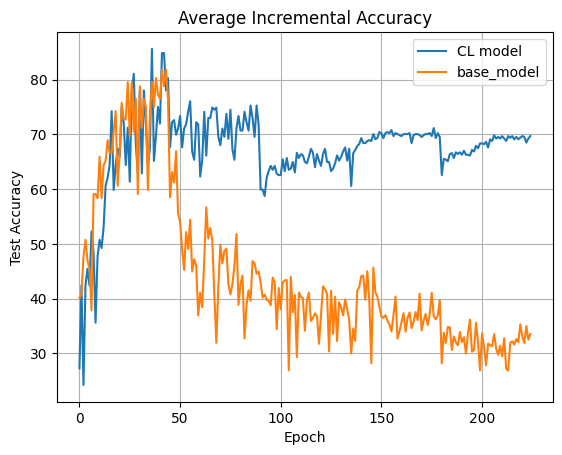

In [ ]:
plot_list(
    [metrics_ltst['avg_acc'], metrics_ltst['avg_acc_base']], y_desc="Test Accuracy", title="Average Incremental Accuracy", save=args.save_plots, filename=filename+'avg_accs'
)

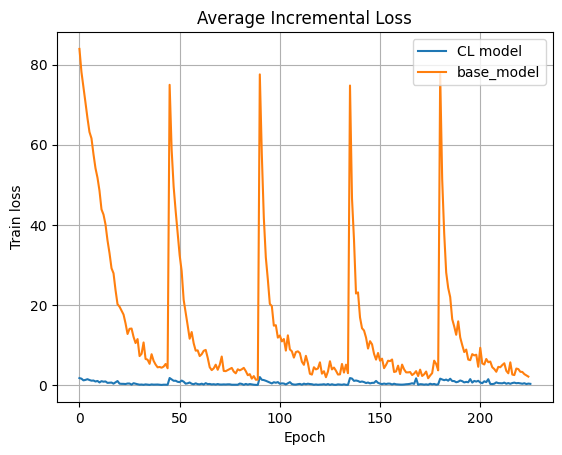

In [ ]:
# Plot train losses
plot_list([metrics_ltst['train_losses'], metrics_ltst['train_losses_base']], y_desc="Train loss", title="Average Incremental Loss", save=True, filename=filename+'train_losses')

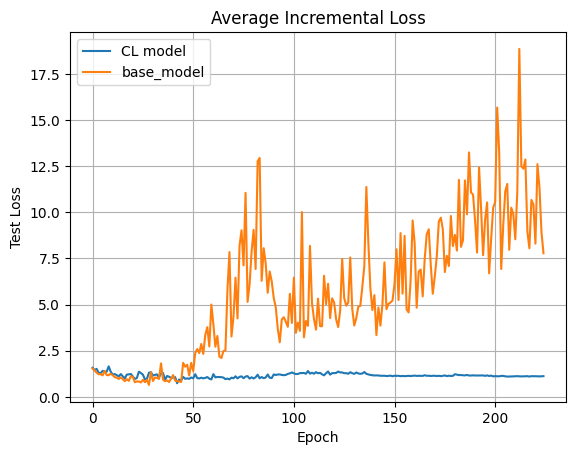

In [ ]:
# Plot test losses
plot_list([metrics_ltst['avg_test_loss'], metrics_ltst['avg_test_loss_base']], y_desc="Test Loss", title="Average Incremental Loss", save=True, filename=filename+'test_losses')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
args.save_plots = True

In [ ]:
def plot_dict(acc_dict, epochs, tasks, y_desc="", title="", save=False, filename=""):
    # Plot elements from dictionary
    plt.figure()
    for i, (task_key, acc_list) in enumerate(acc_dict.items()):
        x = np.arange(i * epochs, tasks * epochs)
        if i != 4:
            plt.plot(x, acc_list[:-1], label=task_key)
        else:
            plt.plot(x, acc_list, label=task_key)
    plt.xlabel("Epoch"), plt.ylabel(y_desc)
    plt.title(title)
    plt.grid(), plt.legend()

    # Save file
    if save:
        plt.savefig("{}.png".format(filename), dpi=300)
    # plt.show()

In [ ]:
len(metrics_ltst['accs']['task_4'])

91

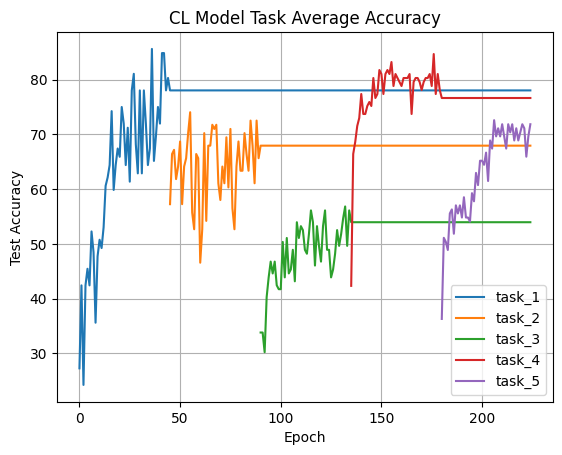

In [ ]:
# Plot accs for each task and Save plot
filename = "store/plots/cl_r2plus1d_taskid_1_to_5_packnet_"
plot_dict(metrics_ltst['accs'], 45, 5, y_desc="Test Accuracy", title="CL Model Task Average Accuracy", save=args.save_plots, filename=filename+"task_cl_model_accs")

In [ ]:
def plot_dict_base(acc_dict, epochs, tasks, y_desc="", title="", save=False, filename=""):
    # Plot elements from dictionary
    plt.figure()
    for i, (task_key, acc_list) in enumerate(acc_dict.items()):
        x = np.arange(i * epochs, tasks * epochs)
        if i != 4:
            plt.plot(x, acc_list, label=task_key)
        else:
            plt.plot(x, acc_list, label=task_key)
    plt.xlabel("Epoch"), plt.ylabel(y_desc)
    plt.title(title)
    plt.grid(), plt.legend()

    # Save file
    if save:
        plt.savefig("{}.png".format(filename), dpi=300)
    # plt.show()

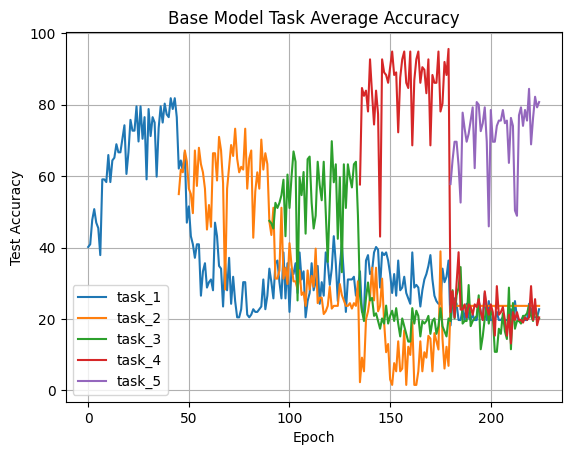

In [ ]:

# Plot accs for each task for BASE MODEL
if args.base_model:
    plot_dict_base(metrics_ltst['accs_base'], args.epochs, 5, y_desc="Test Accuracy", title="Base Model Task Average Accuracy", save=True, filename=filename+"task_base_model_accs")

plt.show()

In [ ]:
t = 2
dl_test = DataLoader(test_datasets_list[t], batch_size=14, shuffle=True)

In [ ]:
test_samples = enumerate(dl_test)

In [ ]:
b, (x, y) = next(test_samples)

In [ ]:
x.shape, y.shape

(torch.Size([14, 3, 32, 112, 112]), torch.Size([14]))

In [ ]:
y

tensor([4, 1, 0, 0, 3, 1, 2, 3, 2, 0, 0, 1, 1, 3])

In [ ]:
model_copy = deepcopy(pruner)
model_copy.apply_mask(dataset_idx=t+1)

model_copy.model.task_nr = t
model_copy.model.set_bn_layer(t)

In [ ]:
with torch.no_grad():
    y_pred = model_copy.model(x.to(device))
    # Process the output
    del x
    torch.cuda.empty_cache()

In [ ]:
y_pred.argmax(dim=-1)

tensor([4, 1, 0, 0, 3, 2, 3, 3, 2, 3, 4, 1, 1, 3], device='cuda:0')

In [ ]:
torch.argmax(y_pred, dim=-1)

tensor([1, 2, 1, 3, 3, 2, 1, 2, 4, 1, 4, 2, 4, 2], device='cuda:0')

In [ ]:
len(train_datasets_list[0]), len(test_datasets_list[0])

(536, 132)

In [ ]:
len(dl_test), len(dl_test.dataset)

(10, 132)

In [ ]:
task_nr = 0
pruner_copy = deepcopy(pruner)
pruner_copy.apply_mask(dataset_idx=t+1)

size = len(dl_test.dataset)
num_batches = len(dl_test)
test_loss, correct = 0.0, 0.0

pruner_copy.model.task_nr = task_nr
pruner_copy.model.set_bn_layer(task_nr)
# List of classes seen so far
active_classes = pruner_copy.model.classes_per_task * (task_nr + 1)

pruner_copy.model.eval()
with torch.no_grad():
    for X, y in dl_test:
        if pruner_copy.model.scenario == "task":
            # changing labels for spilt dataset task
            y = torch.remainder(y, pruner_copy.model.classes_per_task)

        X, y = X.to(device), y.to(device)
        pred = pruner_copy.model.forward(X)

        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size
acc = 100 * correct
print(f"Test Accuracy: {acc:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


Test Accuracy: 78.03%


In [ ]:
!python PackNet.py

Data loaded
+-------------------------------------------------------------+----------------------+------------+
|                           Modules                           |         Size         | Parameters |
+-------------------------------------------------------------+----------------------+------------+
|             res2plus1d.conv1.spatial_conv.weight            |   [83, 3, 1, 7, 7]   |   12201    |
|              res2plus1d.conv1.spatial_conv.bias             |         [83]         |     83     |
|                  res2plus1d.conv1.bn.weight                 |         [83]         |     83     |
|                   res2plus1d.conv1.bn.bias                  |         [83]         |     83     |
|            res2plus1d.conv1.temporal_conv.weight            |  [64, 83, 3, 1, 1]   |   15936    |
|             res2plus1d.conv1.temporal_conv.bias             |         [64]         |     64     |
|      res2plus1d.conv2.block1.conv1.spatial_conv.weight      |  [144, 64, 1, 3, 3]  |  